In [77]:
# Imports
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.inspection import partial_dependence, PartialDependenceDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import shap
warnings.filterwarnings('ignore')


In [78]:
# Load dataset
dataset = pd.read_csv("dataset.csv")

In [79]:
# Define columns to impute with 0
columns_to_impute = [
    # Google spend
    'GOOGLE_PAID_SEARCH_SPEND','GOOGLE_SHOPPING_SPEND','GOOGLE_PMAX_SPEND','GOOGLE_DISPLAY_SPEND','GOOGLE_VIDEO_SPEND',
    # Google impressions
    'GOOGLE_PAID_SEARCH_IMPRESSIONS','GOOGLE_SHOPPING_IMPRESSIONS','GOOGLE_PMAX_IMPRESSIONS','GOOGLE_DISPLAY_IMPRESSIONS','GOOGLE_VIDEO_IMPRESSIONS',
    # Google clicks
    'GOOGLE_PAID_SEARCH_CLICKS','GOOGLE_SHOPPING_CLICKS','GOOGLE_PMAX_CLICKS','GOOGLE_DISPLAY_CLICKS','GOOGLE_VIDEO_CLICKS',
    # Meta spend
    'META_FACEBOOK_SPEND','META_INSTAGRAM_SPEND','META_OTHER_SPEND',
    # Meta impressions
    'META_FACEBOOK_IMPRESSIONS','META_INSTAGRAM_IMPRESSIONS','META_OTHER_IMPRESSIONS',
    # Meta clicks
    'META_FACEBOOK_CLICKS','META_INSTAGRAM_CLICKS','META_OTHER_CLICKS',
    # TikTok
    'TIKTOK_SPEND','TIKTOK_IMPRESSIONS','TIKTOK_CLICKS',
    # Other clicks
    'DIRECT_CLICKS','BRANDED_SEARCH_CLICKS','ORGANIC_SEARCH_CLICKS','EMAIL_CLICKS','REFERRAL_CLICKS','ALL_OTHER_CLICKS'
]

# Create a copy and fill NaNs with 0
dataset_imputed = dataset.copy()
dataset_imputed[columns_to_impute] = dataset_imputed[columns_to_impute].fillna(0)


In [80]:
# Feature engineering - create aggregate features
new_dataset = dataset_imputed.copy()

# Click columns
click_columns = ['GOOGLE_PAID_SEARCH_CLICKS','GOOGLE_SHOPPING_CLICKS','GOOGLE_PMAX_CLICKS','GOOGLE_DISPLAY_CLICKS','GOOGLE_VIDEO_CLICKS',
                'META_FACEBOOK_CLICKS','META_INSTAGRAM_CLICKS','META_OTHER_CLICKS','TIKTOK_CLICKS',
                'DIRECT_CLICKS','BRANDED_SEARCH_CLICKS','ORGANIC_SEARCH_CLICKS','EMAIL_CLICKS','REFERRAL_CLICKS','ALL_OTHER_CLICKS']

# Total clicks
new_dataset['TOTAL_CLICKS'] = new_dataset[click_columns].sum(axis=1)

# Impression columns
impression_columns = ['GOOGLE_PAID_SEARCH_IMPRESSIONS','GOOGLE_SHOPPING_IMPRESSIONS','GOOGLE_PMAX_IMPRESSIONS','GOOGLE_DISPLAY_IMPRESSIONS','GOOGLE_VIDEO_IMPRESSIONS',
                      'META_FACEBOOK_IMPRESSIONS','META_INSTAGRAM_IMPRESSIONS','META_OTHER_IMPRESSIONS',
                      'TIKTOK_IMPRESSIONS']

# Total impressions
new_dataset['TOTAL_IMPRESSIONS'] = new_dataset[impression_columns].sum(axis=1)

# Spend columns
spend_columns = ['GOOGLE_PAID_SEARCH_SPEND','GOOGLE_SHOPPING_SPEND','GOOGLE_PMAX_SPEND','GOOGLE_DISPLAY_SPEND','GOOGLE_VIDEO_SPEND',
                'META_FACEBOOK_SPEND','META_INSTAGRAM_SPEND','META_OTHER_SPEND',
                'TIKTOK_SPEND']

# Total spend
new_dataset['TOTAL_SPEND'] = new_dataset[spend_columns].sum(axis=1)

# Create target variables
new_dataset["ROI"] = new_dataset["ALL_PURCHASES"] / new_dataset["TOTAL_SPEND"]
new_dataset["ROI_RETURNING"] = (new_dataset["ALL_PURCHASES"] - new_dataset["FIRST_PURCHASES"]) / new_dataset["TOTAL_SPEND"]
new_dataset["ROI_FIRST"] = new_dataset["FIRST_PURCHASES"] / new_dataset["TOTAL_SPEND"]
new_dataset["CTR"] = new_dataset["TOTAL_CLICKS"] / new_dataset["TOTAL_IMPRESSIONS"]
new_dataset["CP_DOLLAR"] = new_dataset["TOTAL_SPEND"] / new_dataset["TOTAL_CLICKS"]

# Handle inf and NaN values
new_dataset.replace([np.inf, -np.inf], np.nan, inplace=True)
new_dataset.fillna(0, inplace=True)


In [81]:
# Remove TOTAL_SPEND outliers using 0.05 and 0.995 quantiles
initial_shape = new_dataset.shape
print(f"Dataset shape before removing TOTAL_SPEND outliers: {initial_shape}")
print(f"\nTOTAL_SPEND statistics before outlier removal:")
print(new_dataset['TOTAL_SPEND'].describe())

# Calculate quantiles
lower_quantile = new_dataset['TOTAL_SPEND'].quantile(0.05)
upper_quantile = new_dataset['TOTAL_SPEND'].quantile(0.995)

print(f"\nTOTAL_SPEND quantiles:")
print(f"  5th percentile (lower bound): {lower_quantile:.2f}")
print(f"  99.5th percentile (upper bound): {upper_quantile:.2f}")

# Filter out TOTAL_SPEND outliers
mask_total_spend = (new_dataset['TOTAL_SPEND'] >= lower_quantile) & (new_dataset['TOTAL_SPEND'] <= upper_quantile)
new_dataset = new_dataset[mask_total_spend]

print(f"\nDataset shape after removing TOTAL_SPEND outliers: {new_dataset.shape}")
print(f"Rows removed: {initial_shape[0] - new_dataset.shape[0]}")
print(f"\nTOTAL_SPEND statistics after outlier removal:")
print(new_dataset['TOTAL_SPEND'].describe())


Dataset shape before removing TOTAL_SPEND outliers: (132759, 58)

TOTAL_SPEND statistics before outlier removal:
count    1.327590e+05
mean     9.107843e+03
std      1.054895e+05
min      0.000000e+00
25%      2.257300e+02
50%      7.069470e+02
75%      1.937101e+03
max      8.813257e+06
Name: TOTAL_SPEND, dtype: float64

TOTAL_SPEND quantiles:
  5th percentile (lower bound): 10.25
  99.5th percentile (upper bound): 711932.55

Dataset shape after removing TOTAL_SPEND outliers: (125457, 58)
Rows removed: 7302

TOTAL_SPEND statistics after outlier removal:
count    125457.000000
mean       3102.165152
std       26759.602493
min          10.249629
25%         269.730000
50%         779.780000
75%        2006.290000
max      711689.710000
Name: TOTAL_SPEND, dtype: float64


In [82]:
# Remove outliers using 0.5th and 99.5th percentiles
target_variables = ['ROI_FIRST', 'ROI', 'ROI_RETURNING', 'CTR', 'CP_DOLLAR']

# Calculate percentiles
lower_percentile = new_dataset[target_variables].quantile(0.005)
upper_percentile = new_dataset[target_variables].quantile(0.995)

# Filter out outliers and zeros
mask = True
for var in target_variables:
    mask = mask & (new_dataset[var] >= lower_percentile[var]) & (new_dataset[var] <= upper_percentile[var]) & (new_dataset[var] != 0)

new_dataset = new_dataset[mask]
# Target variable statistics
print(new_dataset[target_variables].describe())


           ROI_FIRST            ROI  ROI_RETURNING            CTR  \
count  116182.000000  116182.000000  116182.000000  116182.000000   
mean        0.085169       0.123403       0.038234       0.031645   
std         0.108372       0.155800       0.069431       0.036781   
min         0.001642       0.002505       0.000104       0.005051   
25%         0.028202       0.040870       0.008862       0.015999   
50%         0.054846       0.077137       0.019112       0.022873   
75%         0.100703       0.143138       0.037707       0.034292   
max         1.296720       2.002427       0.891005       0.638579   

           CP_DOLLAR  
count  116182.000000  
mean        0.451959  
std         0.469631  
min         0.018794  
25%         0.190092  
50%         0.318383  
75%         0.546632  
max         6.008413  


In [83]:
# Prepare features for modeling
# Drop original target columns and outcome columns that wouldn't be known beforehand
new_dataset = new_dataset.drop(columns=['FIRST_PURCHASES', 'ALL_PURCHASES'])

# Drop click columns (outcome variables)
new_dataset = new_dataset.drop(columns=click_columns)

# Drop purchase outcome columns
purchase_outcome_columns = ['FIRST_PURCHASES_UNITS', 'FIRST_PURCHASES_ORIGINAL_PRICE', 'FIRST_PURCHASES_GROSS_DISCOUNT',
                            'ALL_PURCHASES_UNITS', 'ALL_PURCHASES_ORIGINAL_PRICE', 'ALL_PURCHASES_GROSS_DISCOUNT',
                            'TOTAL_CLICKS']
new_dataset = new_dataset.drop(columns=purchase_outcome_columns)

# Select only numeric columns for modeling
model_dataset = new_dataset.select_dtypes(include=[np.number])


In [84]:
# Split into features and targets - USING ALL DATA
X = model_dataset.drop(columns=target_variables)
y = model_dataset[target_variables]

# Split into train / test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [85]:
# Define XGBoost grid searchparameters
xgb_params = {
    'colsample_bytree': 0.8,
    'learning_rate': 0.1,
    'n_estimators': 200,
    'max_depth': 7,
    'random_state': 42,
    'n_jobs': -1
}


In [86]:
# Dictionary to store models
models = {}

# Train a model for each target variable
for target in target_variables:    
    # Initialize XGBoost
    xgb = XGBRegressor(**xgb_params)
    
    # Fit the model
    xgb.fit(X_train, y_train[target])
    
    # Store the model
    models[target] = xgb
    
    print(f"Model trained successfully for {target}")


Model trained successfully for ROI_FIRST
Model trained successfully for ROI
Model trained successfully for ROI_RETURNING
Model trained successfully for CTR
Model trained successfully for CP_DOLLAR


In [87]:
# Evaluate each model on test set
evaluation_results = {}

for target in target_variables:
    # Make predictions
    y_pred = models[target].predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test[target], y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test[target], y_pred)
    r2 = r2_score(y_test[target], y_pred)
    
    # Store results
    evaluation_results[target] = {
        'predictions': y_pred,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    }
    
    # Results for each target
    print(f"Mean Squared Error (MSE):  {mse:.6f}")
    print(f"Root Mean Squared Error:   {rmse:.6f}")
    print(f"Mean Absolute Error (MAE): {mae:.6f}")
    print(f"R² Score:                  {r2:.6f}")


Mean Squared Error (MSE):  0.003313
Root Mean Squared Error:   0.057560
Mean Absolute Error (MAE): 0.029603
R² Score:                  0.716069
Mean Squared Error (MSE):  0.006693
Root Mean Squared Error:   0.081811
Mean Absolute Error (MAE): 0.042841
R² Score:                  0.717746
Mean Squared Error (MSE):  0.001822
Root Mean Squared Error:   0.042688
Mean Absolute Error (MAE): 0.018965
R² Score:                  0.595981
Mean Squared Error (MSE):  0.000330
Root Mean Squared Error:   0.018153
Mean Absolute Error (MAE): 0.008832
R² Score:                  0.720673
Mean Squared Error (MSE):  0.062263
Root Mean Squared Error:   0.249526
Mean Absolute Error (MAE): 0.125168
R² Score:                  0.704342


In [88]:
# Create summary table
summary_df = pd.DataFrame({
    'Target': target_variables,
    'MSE': [evaluation_results[t]['mse'] for t in target_variables],
    'RMSE': [evaluation_results[t]['rmse'] for t in target_variables],
    'MAE': [evaluation_results[t]['mae'] for t in target_variables],
    'R² Score': [evaluation_results[t]['r2'] for t in target_variables]
})

print(summary_df.to_string(index=False))


       Target      MSE     RMSE      MAE  R² Score
    ROI_FIRST 0.003313 0.057560 0.029603  0.716069
          ROI 0.006693 0.081811 0.042841  0.717746
ROI_RETURNING 0.001822 0.042688 0.018965  0.595981
          CTR 0.000330 0.018153 0.008832  0.720673
    CP_DOLLAR 0.062263 0.249526 0.125168  0.704342


## Visualizations
Visualizing model performance and results


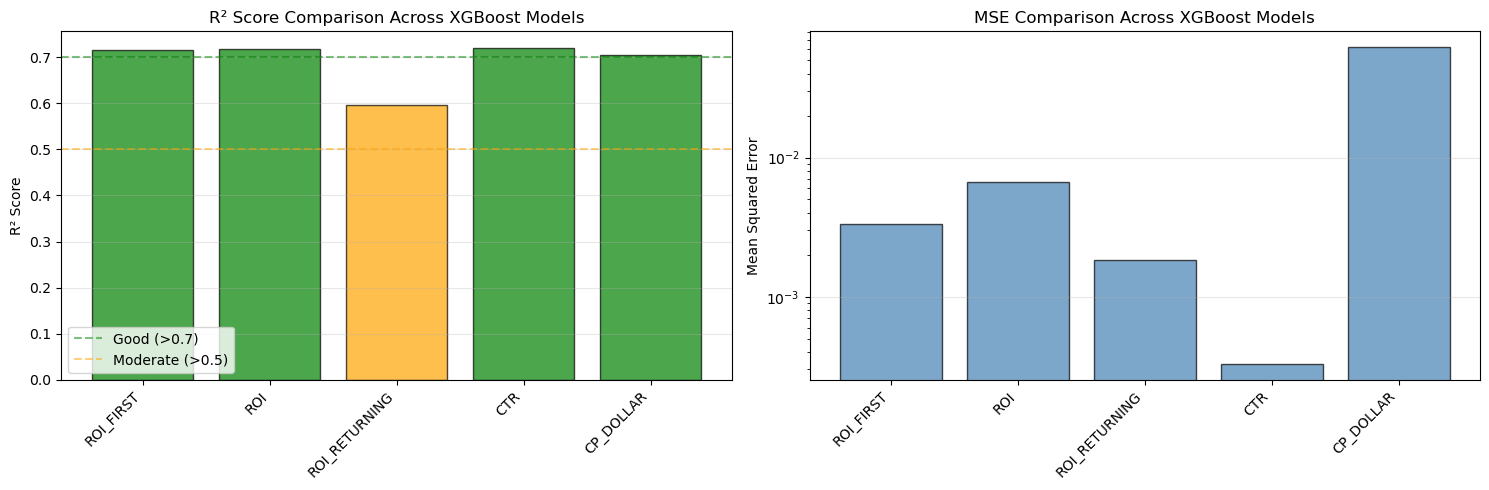

In [89]:
# Plot R² scores and MSE comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# R² Score comparison
r2_scores = [evaluation_results[t]['r2'] for t in target_variables]
colors = ['green' if r2 > 0.7 else 'orange' if r2 > 0.5 else 'red' for r2 in r2_scores]

axes[0].bar(range(len(target_variables)), r2_scores, color=colors, alpha=0.7, edgecolor='black')
axes[0].set_xticks(range(len(target_variables)))
axes[0].set_xticklabels(target_variables, rotation=45, ha='right')
axes[0].set_ylabel('R² Score')
axes[0].set_title('R² Score Comparison Across XGBoost Models')
axes[0].axhline(y=0.7, color='green', linestyle='--', alpha=0.5, label='Good (>0.7)')
axes[0].axhline(y=0.5, color='orange', linestyle='--', alpha=0.5, label='Moderate (>0.5)')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# MSE comparison (log scale for better visualization)
mse_scores = [evaluation_results[t]['mse'] for t in target_variables]
axes[1].bar(range(len(target_variables)), mse_scores, color='steelblue', alpha=0.7, edgecolor='black')
axes[1].set_xticks(range(len(target_variables)))
axes[1].set_xticklabels(target_variables, rotation=45, ha='right')
axes[1].set_ylabel('Mean Squared Error')
axes[1].set_title('MSE Comparison Across XGBoost Models')
axes[1].set_yscale('log')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


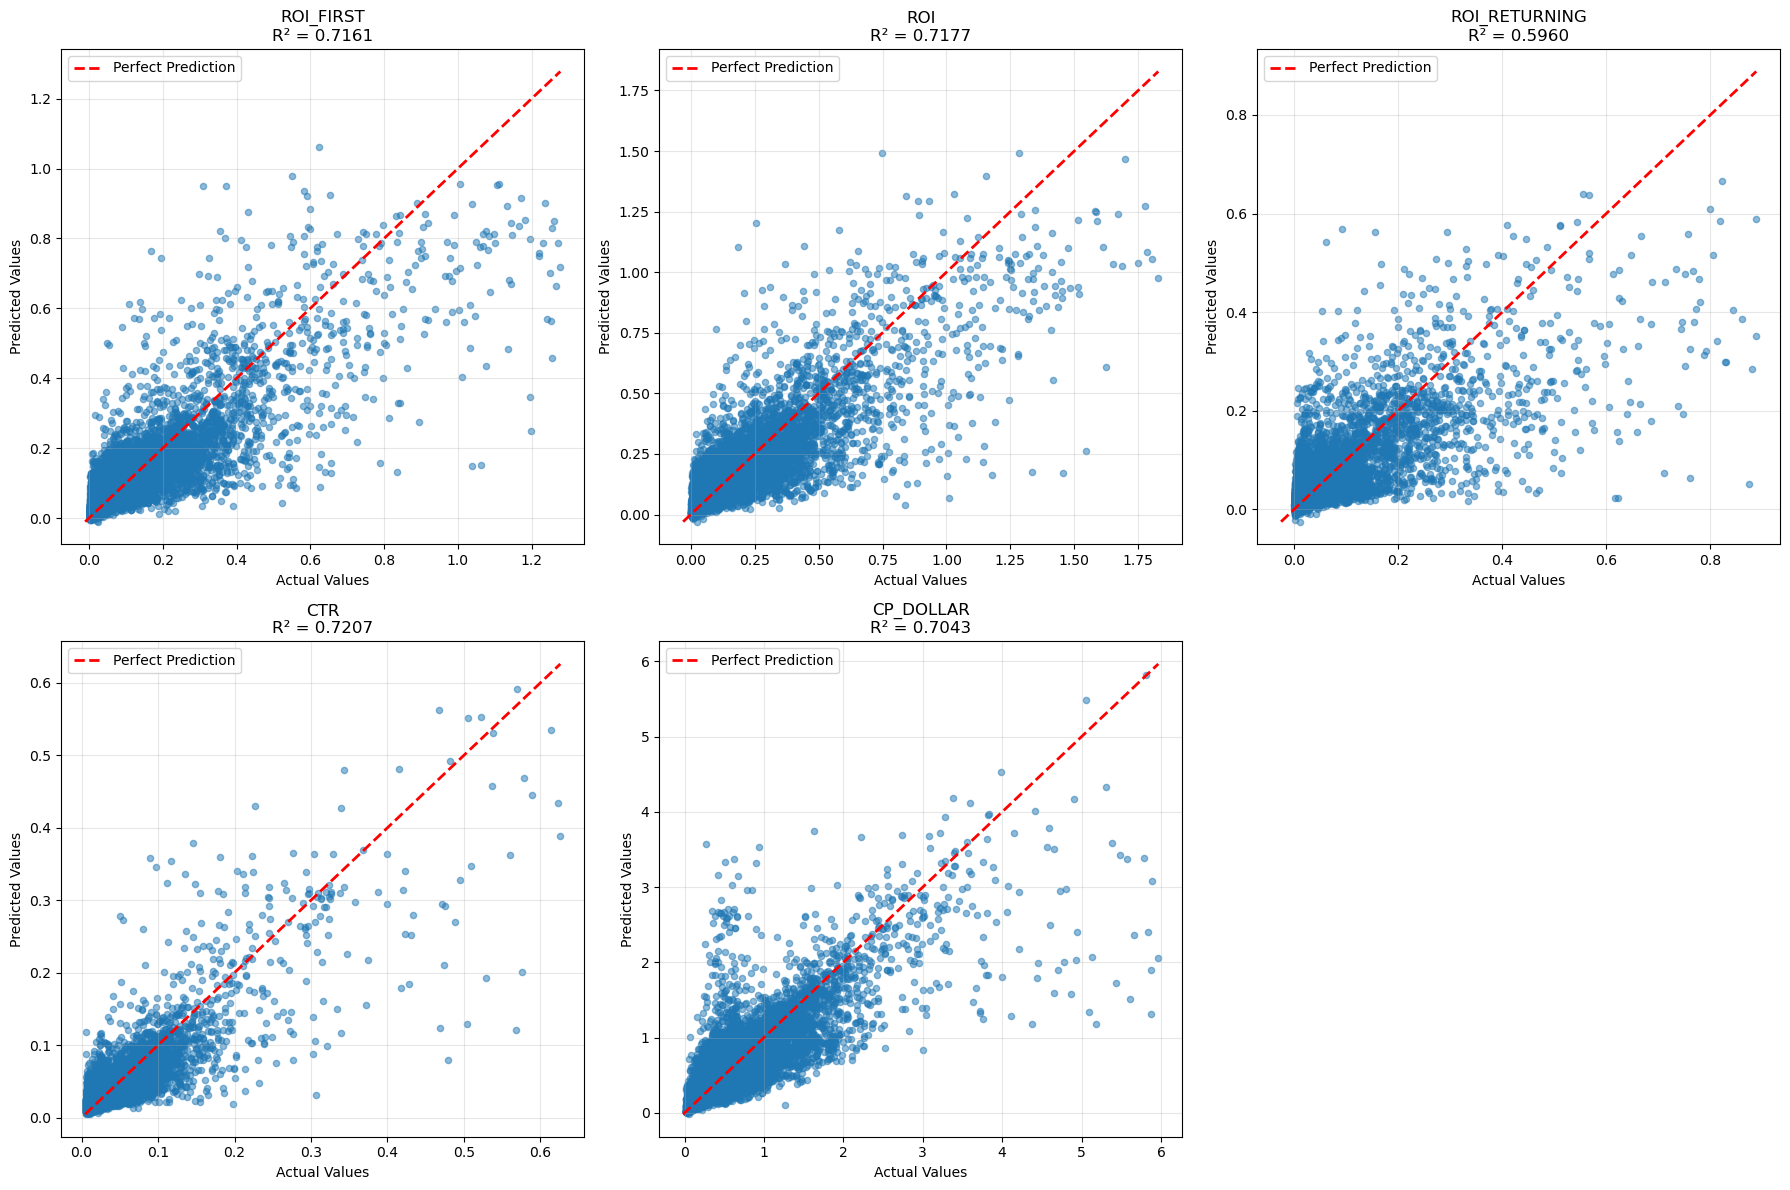

In [90]:
# Actual vs Predicted plots for each target
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, target in enumerate(target_variables):
    y_true = y_test[target]
    y_pred = evaluation_results[target]['predictions']
    r2 = evaluation_results[target]['r2']
    
    # Scatter plot
    axes[idx].scatter(y_true, y_pred, alpha=0.5, s=20)
    
    # Perfect prediction line
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    axes[idx].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    
    axes[idx].set_xlabel('Actual Values')
    axes[idx].set_ylabel('Predicted Values')
    axes[idx].set_title(f'{target}\nR² = {r2:.4f}')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

# Hide the extra subplot
axes[5].axis('off')

plt.tight_layout()
plt.show()


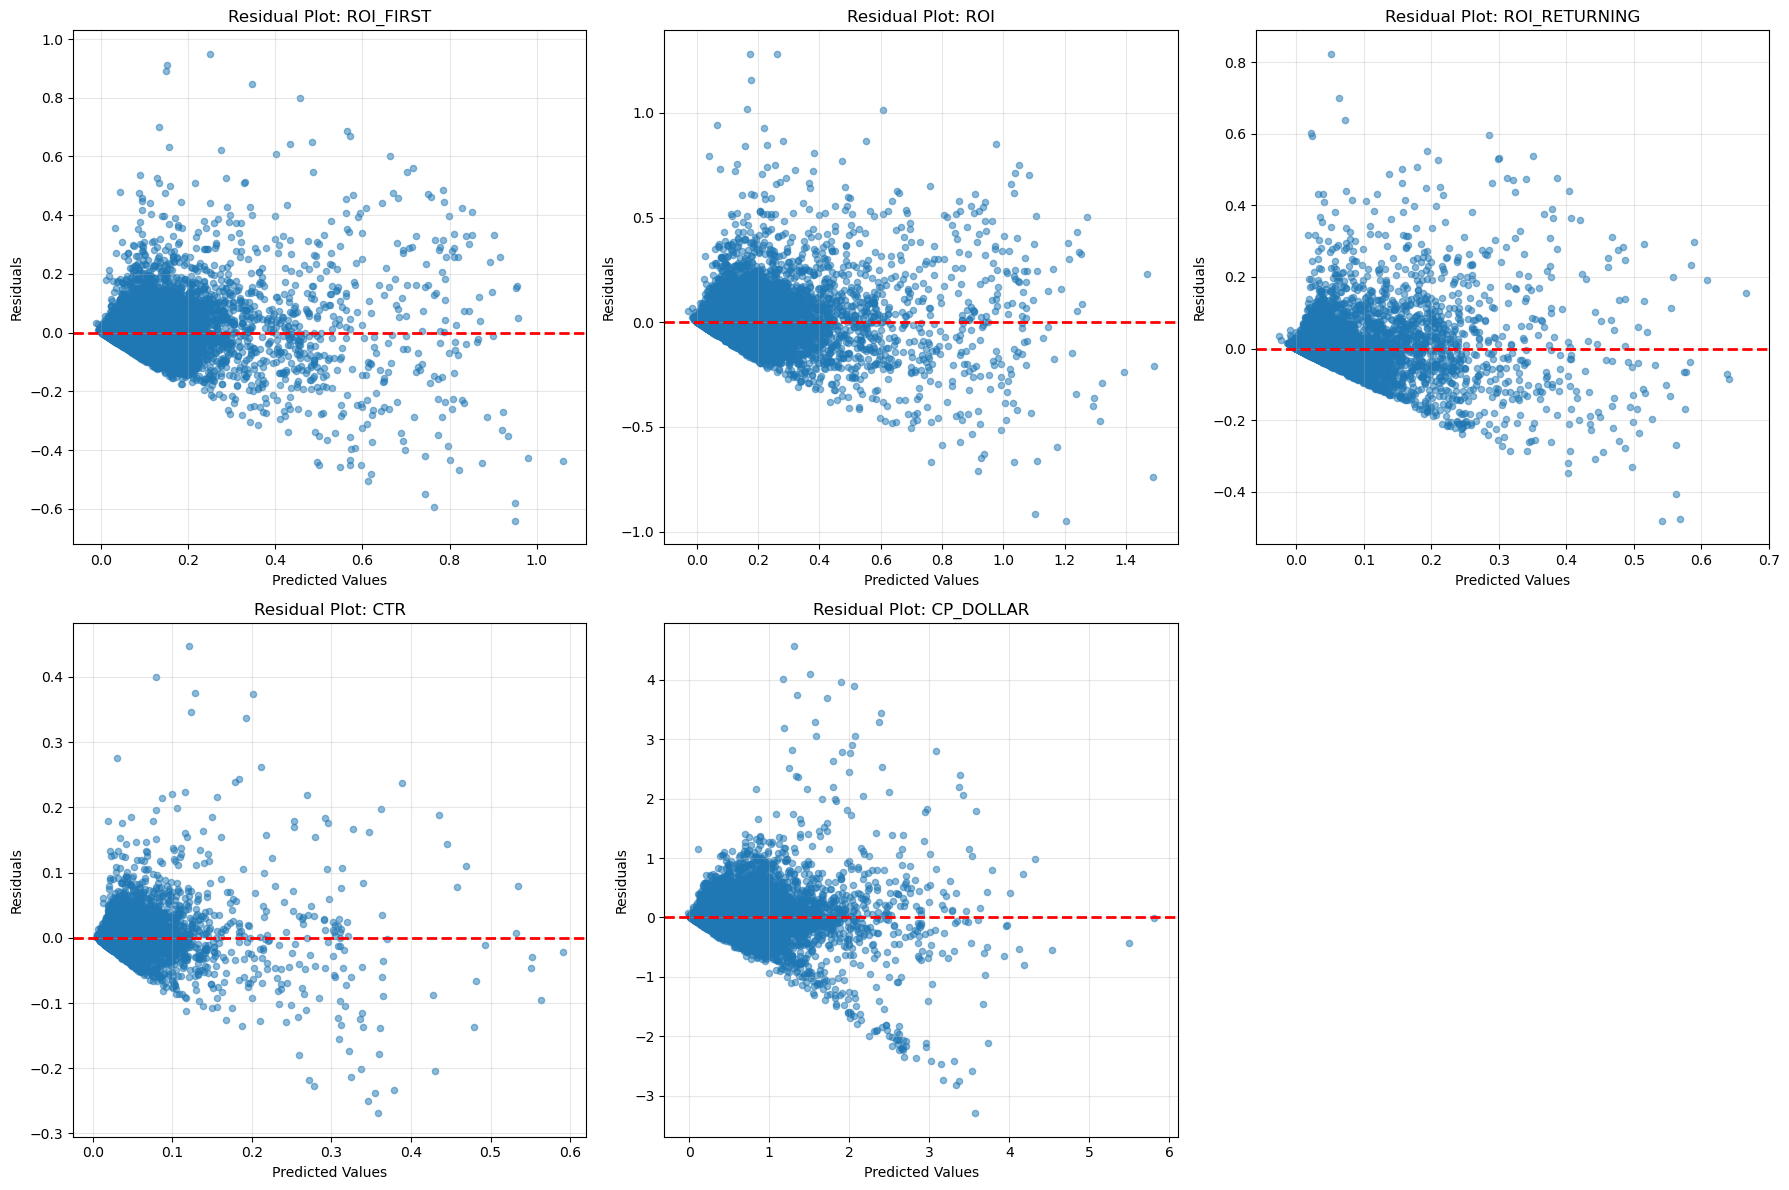

In [91]:
# Residual plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, target in enumerate(target_variables):
    y_true = y_test[target]
    y_pred = evaluation_results[target]['predictions']
    residuals = y_true - y_pred
    
    # Residual plot
    axes[idx].scatter(y_pred, residuals, alpha=0.5, s=20)
    axes[idx].axhline(y=0, color='r', linestyle='--', lw=2)
    axes[idx].set_xlabel('Predicted Values')
    axes[idx].set_ylabel('Residuals')
    axes[idx].set_title(f'Residual Plot: {target}')
    axes[idx].grid(alpha=0.3)

# Hide the extra subplot
axes[5].axis('off')

plt.tight_layout()
plt.show()


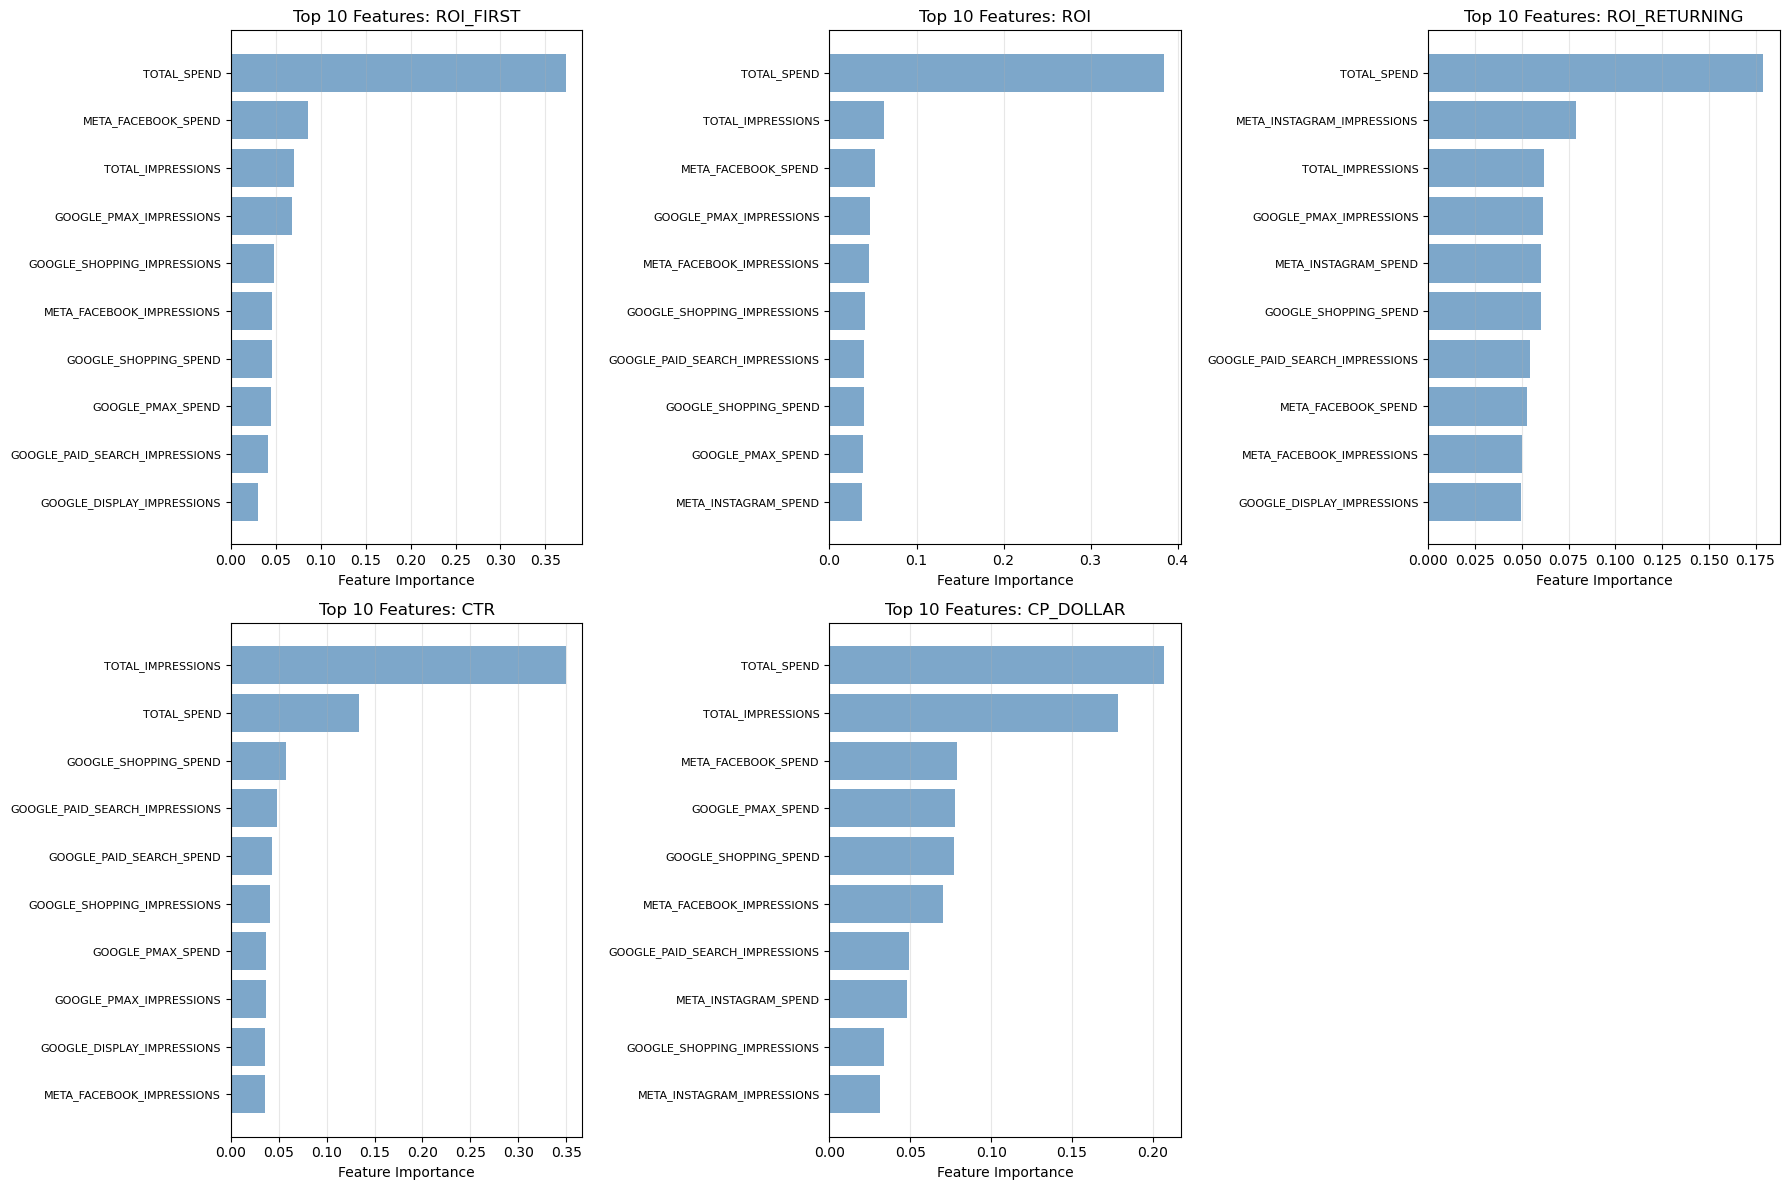

In [92]:
# Feature importance plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

feature_names = X_train.columns

for idx, target in enumerate(target_variables):
    importances = models[target].feature_importances_
    # Top 10 features
    indices = np.argsort(importances)[::-1][:10]  
    
    axes[idx].barh(range(10), importances[indices], color='steelblue', alpha=0.7)
    axes[idx].set_yticks(range(10))
    axes[idx].set_yticklabels([feature_names[i] for i in indices], fontsize=8)
    axes[idx].set_xlabel('Feature Importance')
    axes[idx].set_title(f'Top 10 Features: {target}')
    axes[idx].invert_yaxis()
    axes[idx].grid(axis='x', alpha=0.3)

# Hide the extra subplot
axes[5].axis('off')

plt.tight_layout()
plt.show()


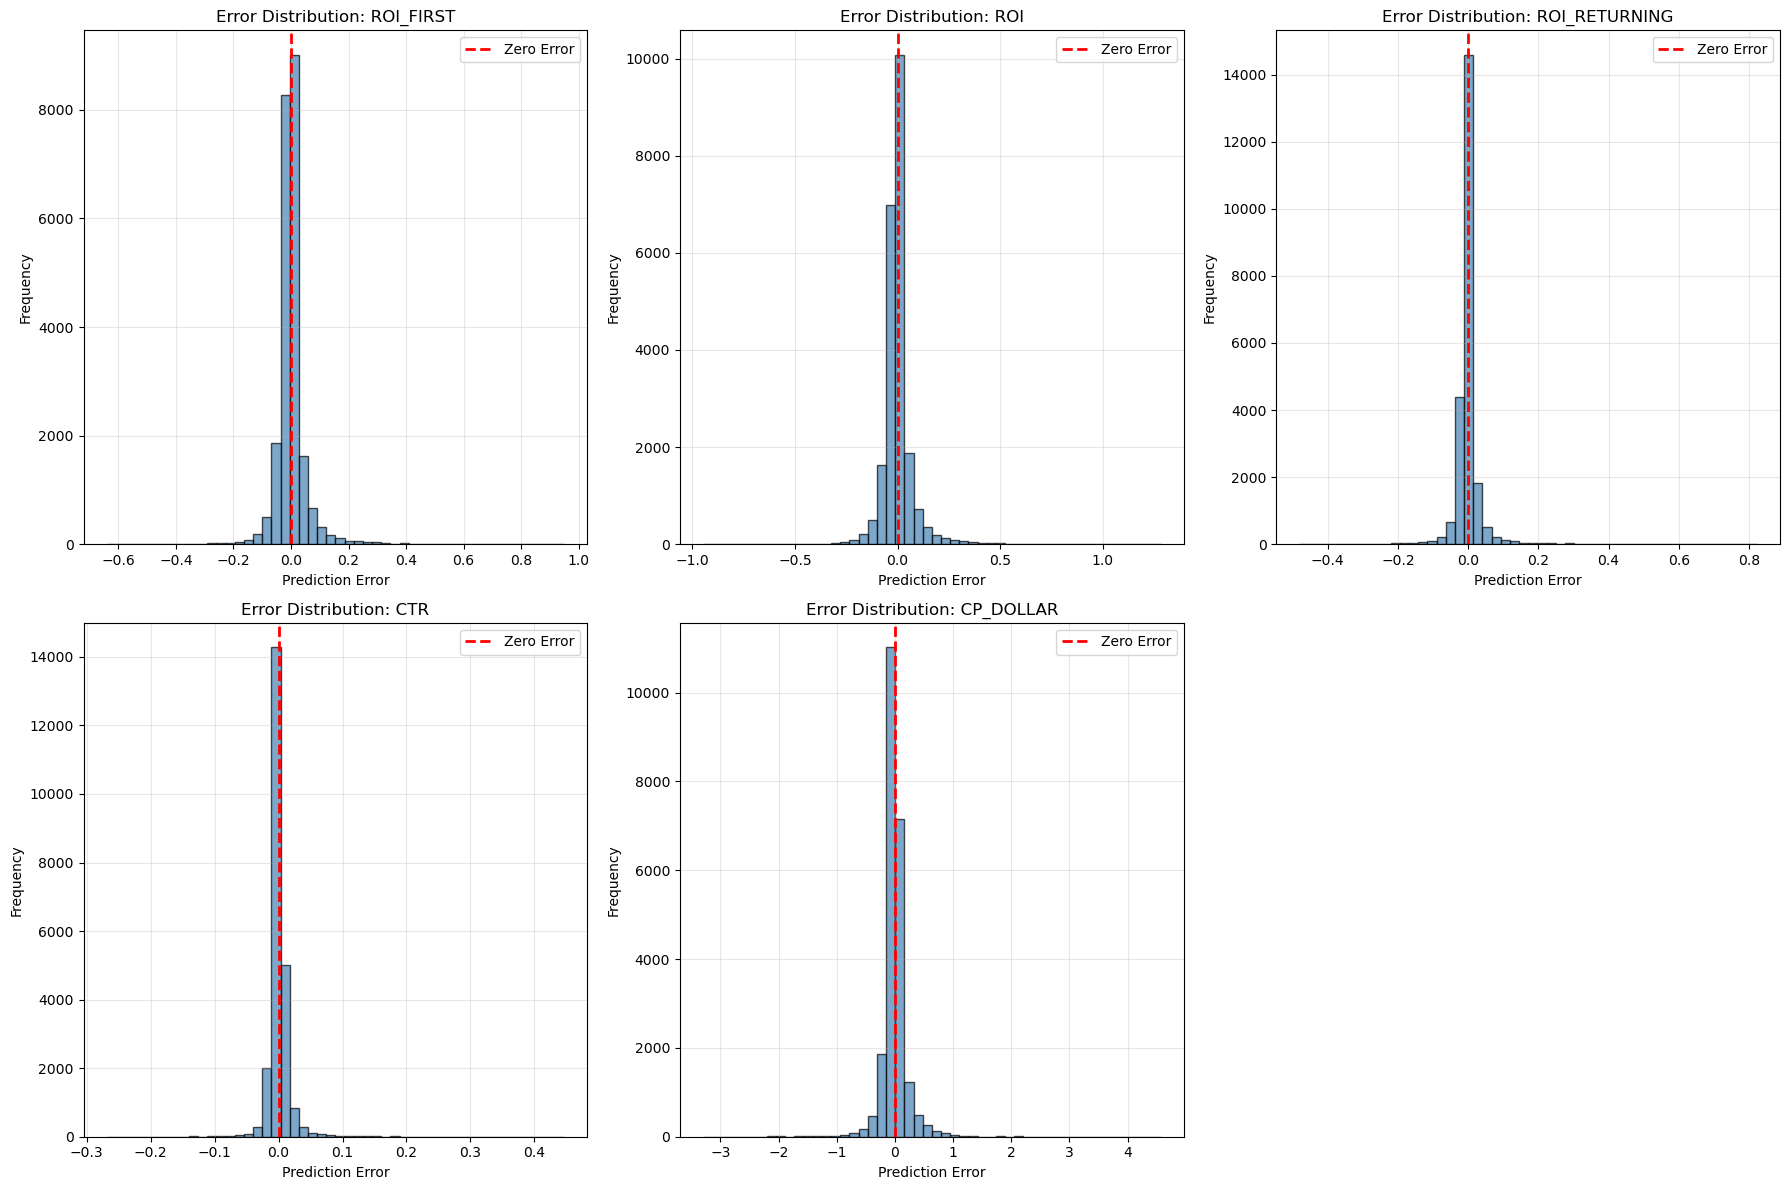

In [93]:
# Error distribution plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, target in enumerate(target_variables):
    y_true = y_test[target]
    y_pred = evaluation_results[target]['predictions']
    errors = y_true - y_pred
    
    # Histogram of errors
    axes[idx].hist(errors, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
    axes[idx].axvline(x=0, color='r', linestyle='--', lw=2, label='Zero Error')
    axes[idx].set_xlabel('Prediction Error')
    axes[idx].set_ylabel('Frequency')
    axes[idx].set_title(f'Error Distribution: {target}')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

# Hide the extra subplot
axes[5].axis('off')

plt.tight_layout()
plt.show()


## Feature Importance Analysis
Detailed feature importance for each target variable

In [94]:
for target in target_variables:
    print("Target: ", target)
    importances = models[target].feature_importances_
    indices = np.argsort(importances)[::-1]
    for i, idx in enumerate(indices[:10], 1):
        print(f"Rank: {i} Feature: {feature_names[idx]} Importance: {importances[idx]}")


Target:  ROI_FIRST
Rank: 1 Feature: TOTAL_SPEND Importance: 0.37259146571159363
Rank: 2 Feature: META_FACEBOOK_SPEND Importance: 0.08571327477693558
Rank: 3 Feature: TOTAL_IMPRESSIONS Importance: 0.0709076076745987
Rank: 4 Feature: GOOGLE_PMAX_IMPRESSIONS Importance: 0.0686550959944725
Rank: 5 Feature: GOOGLE_SHOPPING_IMPRESSIONS Importance: 0.04843549430370331
Rank: 6 Feature: META_FACEBOOK_IMPRESSIONS Importance: 0.046206988394260406
Rank: 7 Feature: GOOGLE_SHOPPING_SPEND Importance: 0.045786626636981964
Rank: 8 Feature: GOOGLE_PMAX_SPEND Importance: 0.044782605022192
Rank: 9 Feature: GOOGLE_PAID_SEARCH_IMPRESSIONS Importance: 0.0410948246717453
Rank: 10 Feature: GOOGLE_DISPLAY_IMPRESSIONS Importance: 0.02980818785727024
Target:  ROI
Rank: 1 Feature: TOTAL_SPEND Importance: 0.3849223852157593
Rank: 2 Feature: TOTAL_IMPRESSIONS Importance: 0.06300593167543411
Rank: 3 Feature: META_FACEBOOK_SPEND Importance: 0.05245134234428406
Rank: 4 Feature: GOOGLE_PMAX_IMPRESSIONS Importance: 0.046

In [95]:
# Calculate correlations for each target variable
correlation_results = {}

for target in target_variables:
    print("Target: ", target)
    
    # Calculate correlations between all features and target
    correlations = {}
    for feat in feature_names:
        corr = model_dataset[feat].corr(model_dataset[target])
        correlations[feat] = corr
    
    # Sort by absolute correlation value
    sorted_corrs = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True)
    
    correlation_results[target] = correlations
    
    # Display top features with positive and negative correlations
    print(f"\nTop Features with POSITIVE Correlation (increase {target}):")
    positive_features = [(f, c) for f, c in sorted_corrs if c > 0]
    for rank, (feat, corr) in enumerate(positive_features[:10], 1):
        if abs(corr) > 0.01:  # Only show meaningful correlations
            print(f"Rank: {rank} Feature: {feat} Correlation: {corr} Direction: ↑ Increases")
    
    print(f"\nTop Features with NEGATIVE Correlation (decrease {target}):")
    negative_features = [(f, c) for f, c in sorted_corrs if c < 0]
    for rank, (feat, corr) in enumerate(negative_features[:10], 1):
        if abs(corr) > 0.01:  # Only show meaningful correlations
            print(f"Rank: {rank} Feature: {feat} Correlation: {corr} Direction: ↓ Decreases")


Target:  ROI_FIRST

Top Features with POSITIVE Correlation (increase ROI_FIRST):
Rank: 1 Feature: GOOGLE_SHOPPING_IMPRESSIONS Correlation: 0.025642695046844858 Direction: ↑ Increases

Top Features with NEGATIVE Correlation (decrease ROI_FIRST):
Rank: 1 Feature: TOTAL_SPEND Correlation: -0.202595303097741 Direction: ↓ Decreases
Rank: 2 Feature: META_FACEBOOK_SPEND Correlation: -0.19318811258345517 Direction: ↓ Decreases
Rank: 3 Feature: META_FACEBOOK_IMPRESSIONS Correlation: -0.1698643968196311 Direction: ↓ Decreases
Rank: 4 Feature: TOTAL_IMPRESSIONS Correlation: -0.1277273123364869 Direction: ↓ Decreases
Rank: 5 Feature: META_INSTAGRAM_SPEND Correlation: -0.12448590606274175 Direction: ↓ Decreases
Rank: 6 Feature: GOOGLE_PMAX_SPEND Correlation: -0.11823578909876818 Direction: ↓ Decreases
Rank: 7 Feature: META_INSTAGRAM_IMPRESSIONS Correlation: -0.11039522651730778 Direction: ↓ Decreases
Rank: 8 Feature: GOOGLE_PMAX_IMPRESSIONS Correlation: -0.10859585116447074 Direction: ↓ Decreases
R

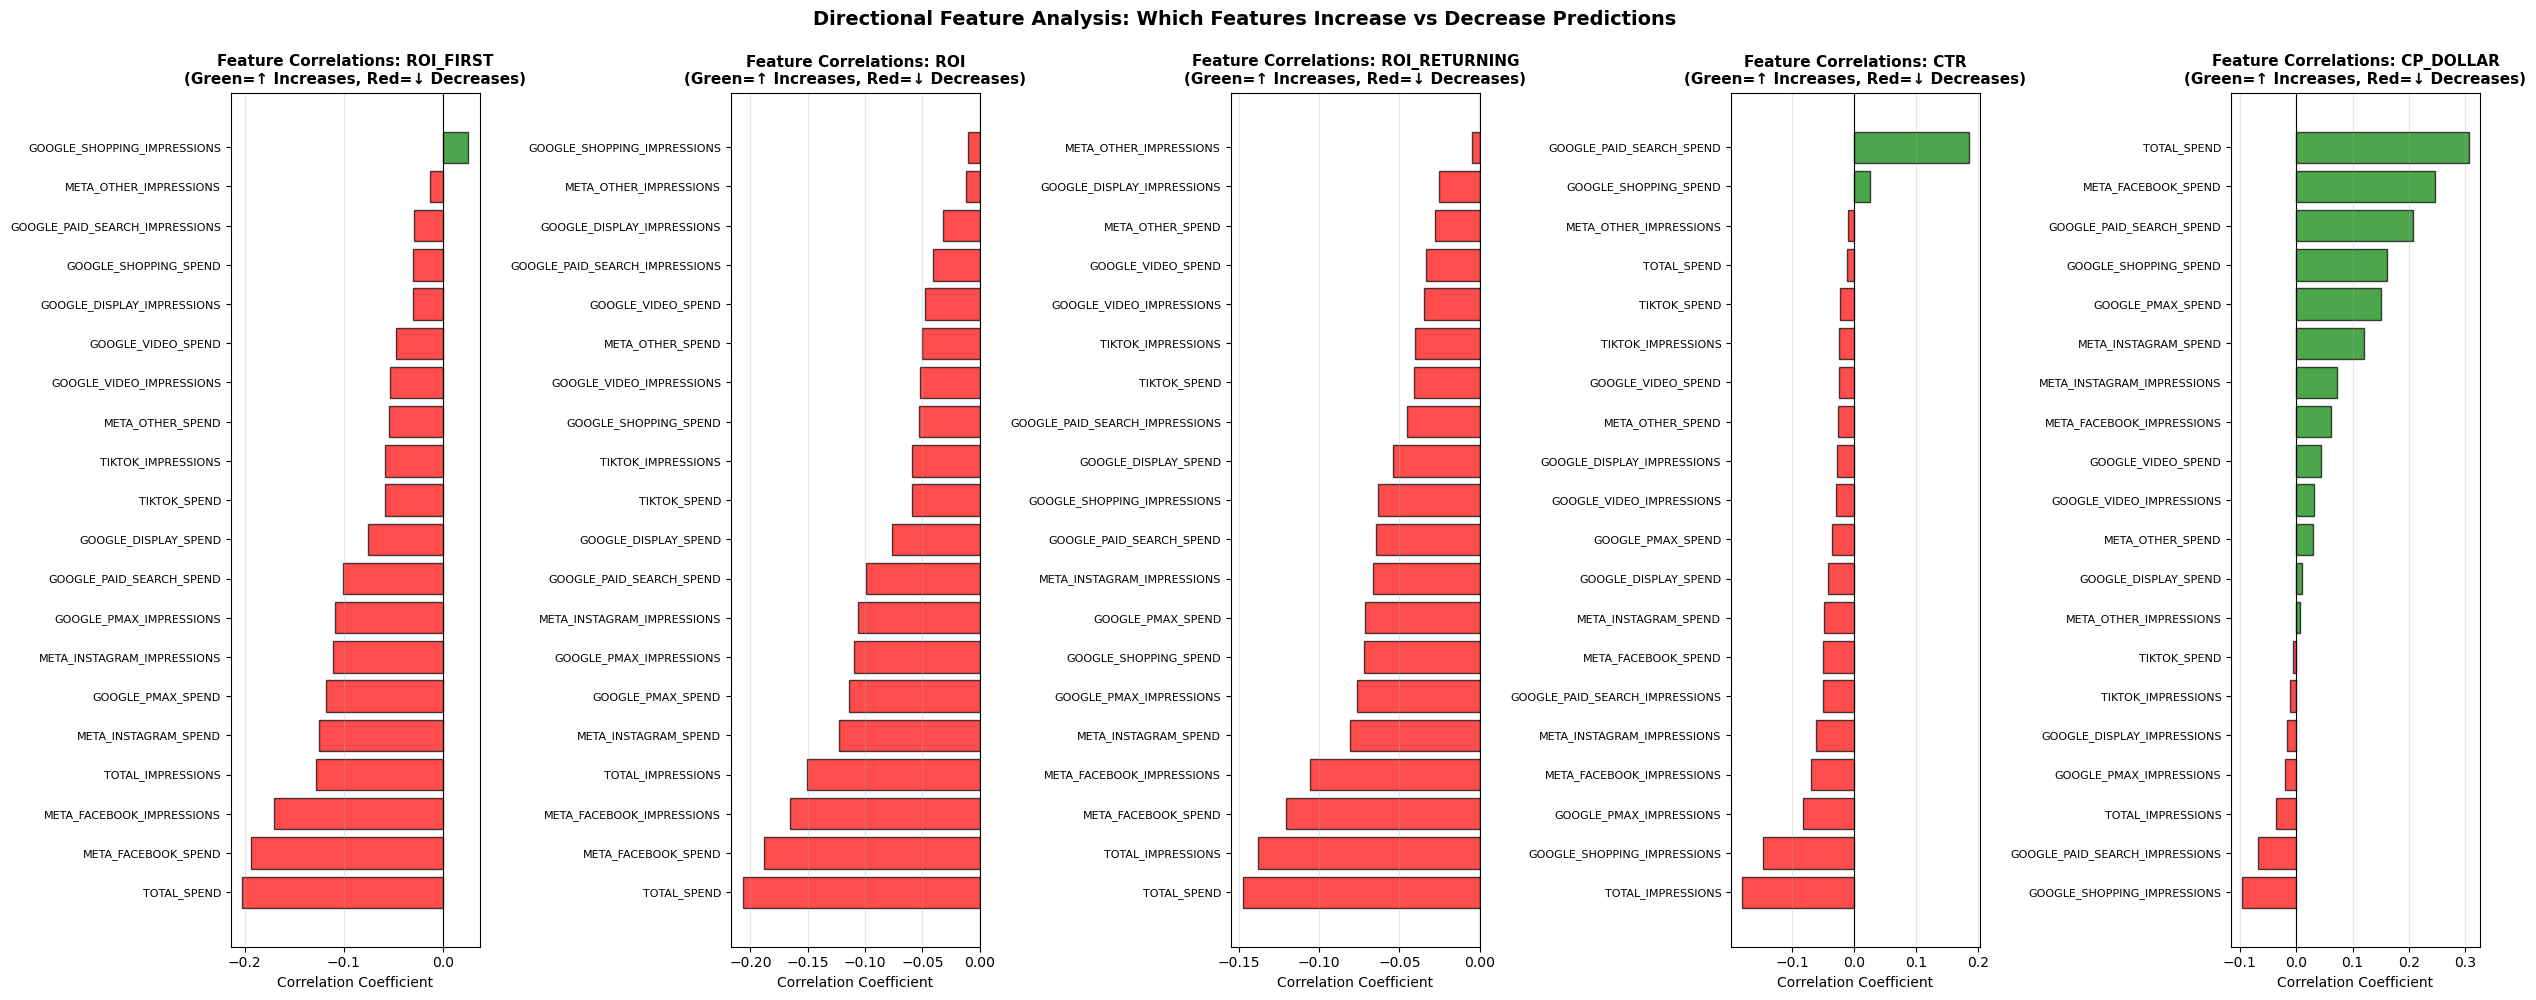

In [96]:
# Visualize correlations as heatmap
fig, axes = plt.subplots(1, len(target_variables), figsize=(5*len(target_variables), 10))
if len(target_variables) == 1:
    axes = [axes]

for idx, target in enumerate(target_variables):
    # Get correlations for this target
    corrs = correlation_results[target]
    
    # Create DataFrame for heatmap
    corr_df = pd.DataFrame({
        'Feature': list(corrs.keys()),
        'Correlation': list(corrs.values())
    })
    corr_df = corr_df.sort_values('Correlation', ascending=False)
    
    # Create bar plot
    colors = ['green' if c > 0 else 'red' for c in corr_df['Correlation']]
    axes[idx].barh(range(len(corr_df)), corr_df['Correlation'], color=colors, alpha=0.7, edgecolor='black')
    axes[idx].set_yticks(range(len(corr_df)))
    axes[idx].set_yticklabels(corr_df['Feature'], fontsize=8)
    axes[idx].set_xlabel('Correlation Coefficient', fontsize=10)
    axes[idx].set_title(f'Feature Correlations: {target}\n(Green=↑ Increases, Red=↓ Decreases)', 
                       fontsize=11, fontweight='bold')
    axes[idx].axvline(x=0, color='black', linestyle='-', linewidth=0.8)
    axes[idx].grid(axis='x', alpha=0.3)
    axes[idx].invert_yaxis()

plt.suptitle('Directional Feature Analysis: Which Features Increase vs Decrease Predictions', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


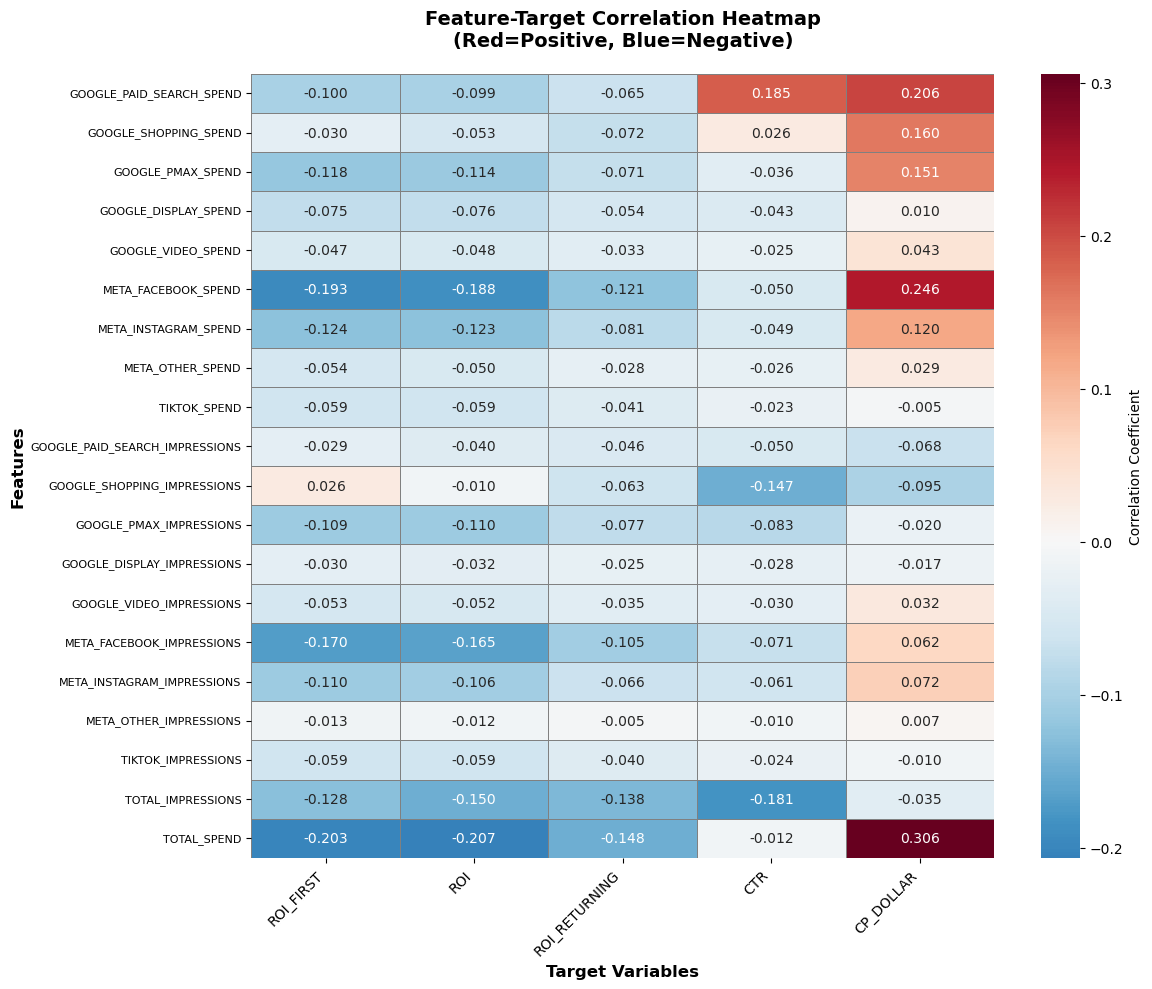

In [97]:
# Create comprehensive correlation heatmap across all targets
corr_matrix = pd.DataFrame({
    target: [correlation_results[target][feat] for feat in feature_names]
    for target in target_variables
}, index=feature_names)

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='RdBu_r', center=0,
            cbar_kws={'label': 'Correlation Coefficient'}, 
            xticklabels=target_variables, yticklabels=feature_names,
            linewidths=0.5, linecolor='gray')
plt.title('Feature-Target Correlation Heatmap\n(Red=Positive, Blue=Negative)', 
         fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Target Variables', fontsize=12, fontweight='bold')
plt.ylabel('Features', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()


In [98]:
for target in target_variables:
    importances = models[target].feature_importances_
    indices = np.argsort(importances)[::-1][:3]
    print(f"To MAXIMIZE {target}:")
    
    for rank, idx in enumerate(indices, 1):
        feat_name = feature_names[idx]
        corr = model_dataset[feat_name].corr(model_dataset[target])
        importance = importances[idx]
        
        if corr > 0:
            action = "INCREASE"
            reasoning = "shows positive correlation"
        else:
            action = "DECREASE"
            reasoning = "shows negative correlation"
        
        print(f"\n{rank}. {action} {feat_name}")
        print(f"    - Importance Score: {importance}")
        print(f"    - Correlation: {corr} ({reasoning})")
        
        # Add context-specific recommendations
        if 'SPEND' in feat_name and corr > 0:
            print(f"    - Strategy: Allocate more budget to this channel")
        elif 'SPEND' in feat_name and corr < 0:
            print(f"    - Strategy: Reduce spend or optimize efficiency")
        elif 'IMPRESSION' in feat_name and corr > 0:
            print(f"    - Strategy: Increase reach and visibility")
        elif 'IMPRESSION' in feat_name and corr < 0:
            print(f"    - Strategy: Focus on quality over quantity")


To MAXIMIZE ROI_FIRST:

1. DECREASE TOTAL_SPEND
    - Importance Score: 0.37259146571159363
    - Correlation: -0.202595303097741 (shows negative correlation)
    - Strategy: Reduce spend or optimize efficiency

2. DECREASE META_FACEBOOK_SPEND
    - Importance Score: 0.08571327477693558
    - Correlation: -0.19318811258345517 (shows negative correlation)
    - Strategy: Reduce spend or optimize efficiency

3. DECREASE TOTAL_IMPRESSIONS
    - Importance Score: 0.0709076076745987
    - Correlation: -0.1277273123364869 (shows negative correlation)
    - Strategy: Focus on quality over quantity
To MAXIMIZE ROI:

1. DECREASE TOTAL_SPEND
    - Importance Score: 0.3849223852157593
    - Correlation: -0.20666480907056076 (shows negative correlation)
    - Strategy: Reduce spend or optimize efficiency

2. DECREASE TOTAL_IMPRESSIONS
    - Importance Score: 0.06300593167543411
    - Correlation: -0.15031645006380254 (shows negative correlation)
    - Strategy: Focus on quality over quantity

3. D

In [99]:
shap_values_dict = {}
X_shap_sample = None

# Use a smaller sample for SHAP (it's computationally expensive)
shap_sample_size = min(1000, len(X_train))
shap_sample_indices = np.random.choice(len(X_train), shap_sample_size, replace=False)
X_shap_sample = X_train.iloc[shap_sample_indices]

# Store SHAP explainers and values
shap_explainers = {}

# Calculate SHAP values for each model
for target in target_variables:
    try:
        # Create SHAP explainer (TreeExplainer for XGBoost)
        explainer = shap.TreeExplainer(models[target])
        shap_values = explainer.shap_values(X_shap_sample)
        
        shap_explainers[target] = explainer
        shap_values_dict[target] = shap_values
        
    except Exception:
        continue



ROI_FIRST:


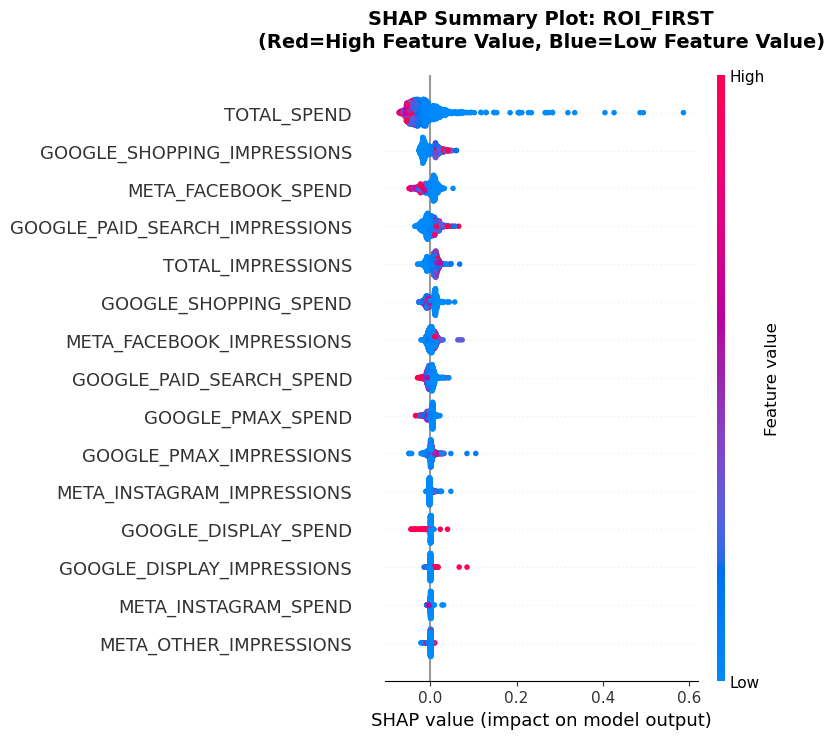

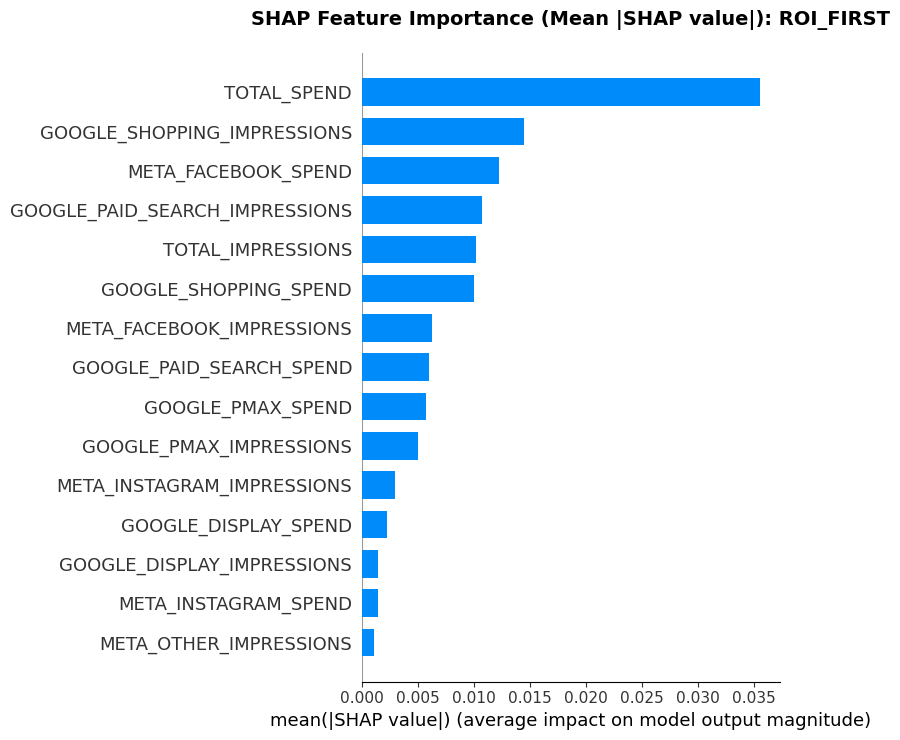


ROI:


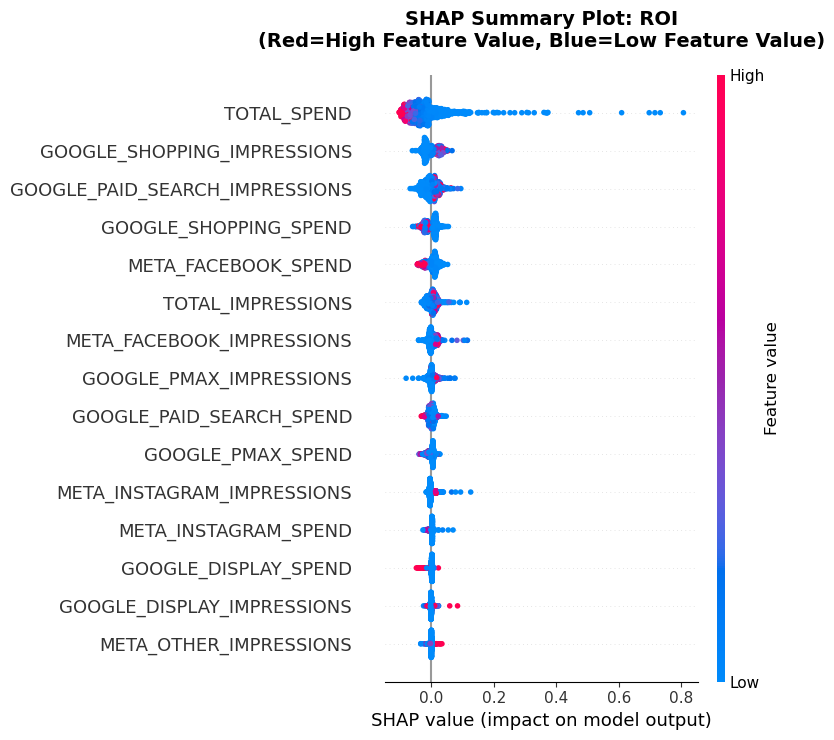

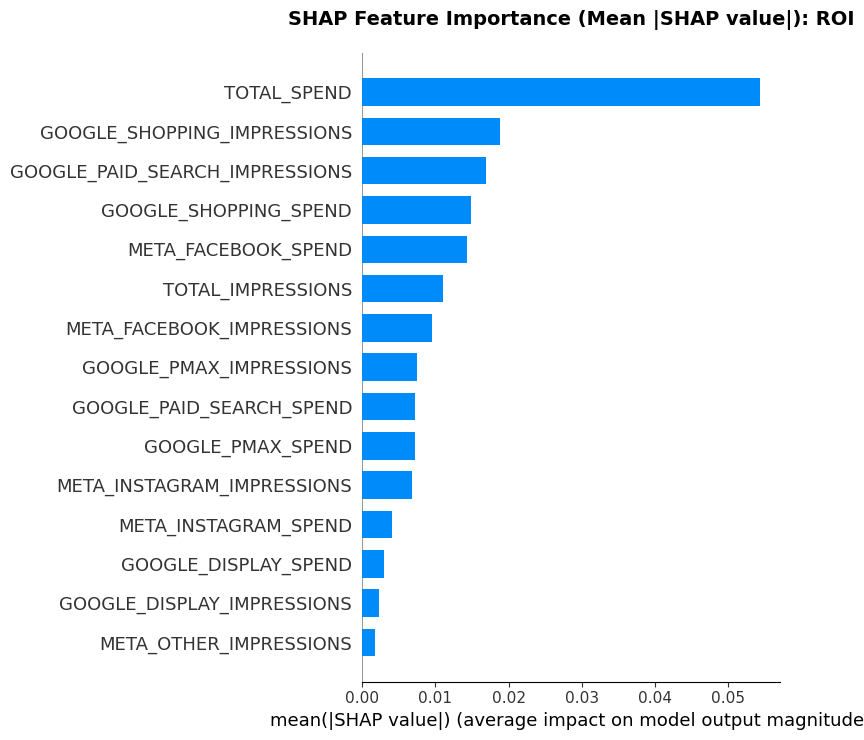


ROI_RETURNING:


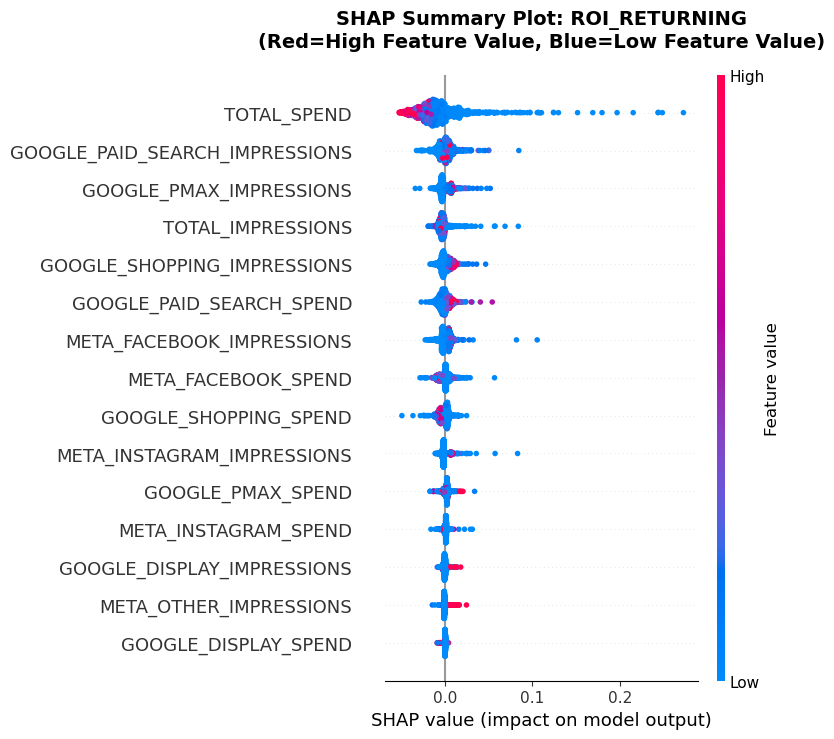

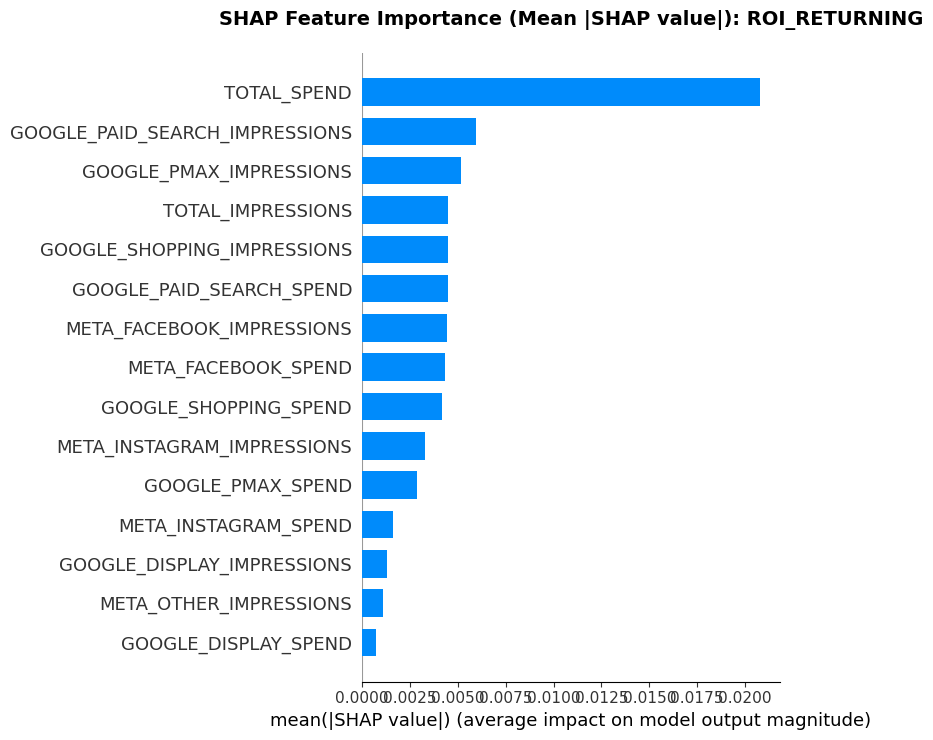


CTR:


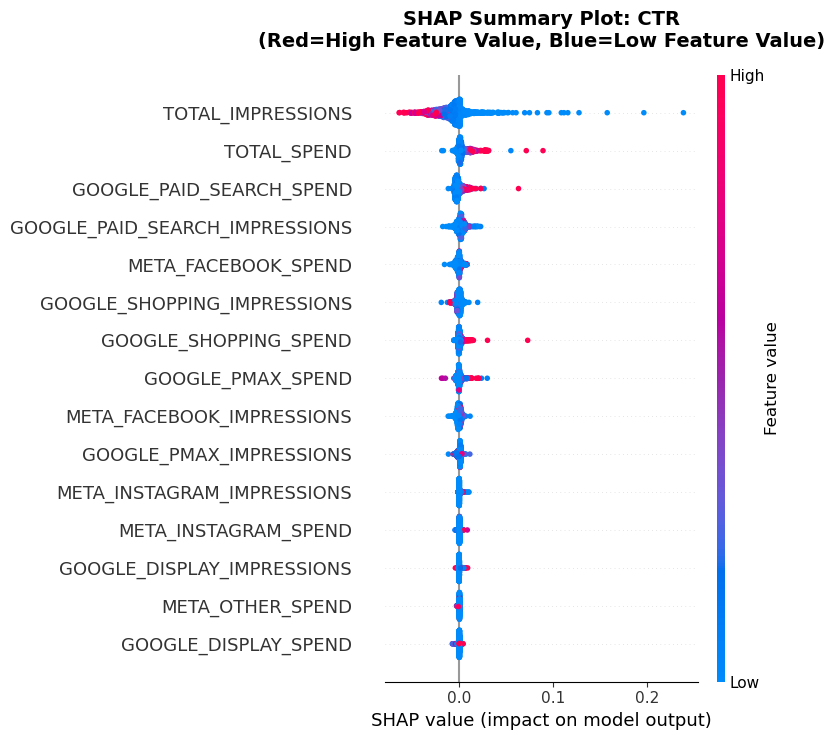

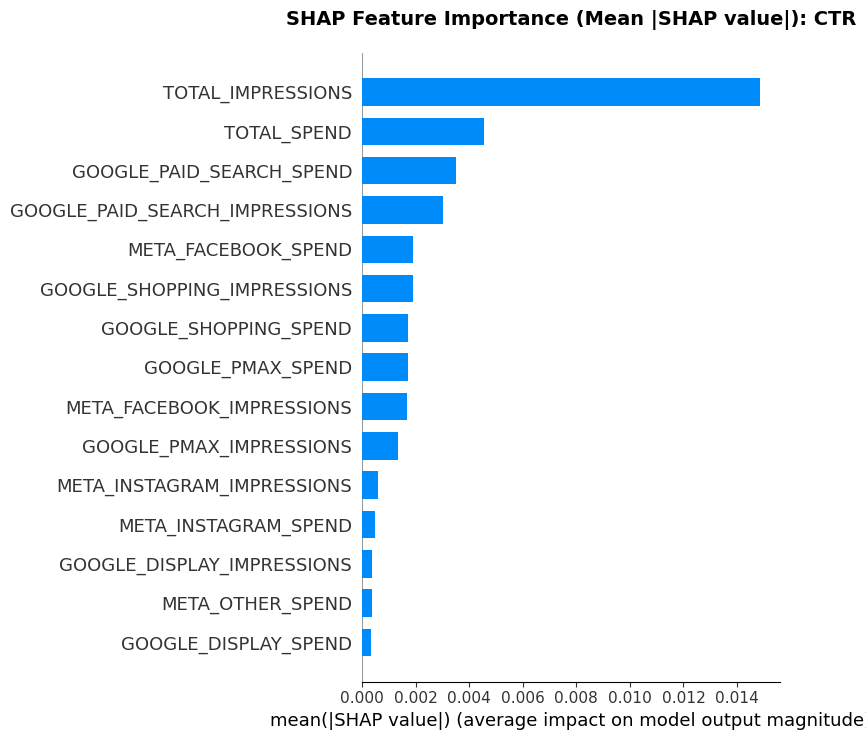


CP_DOLLAR:


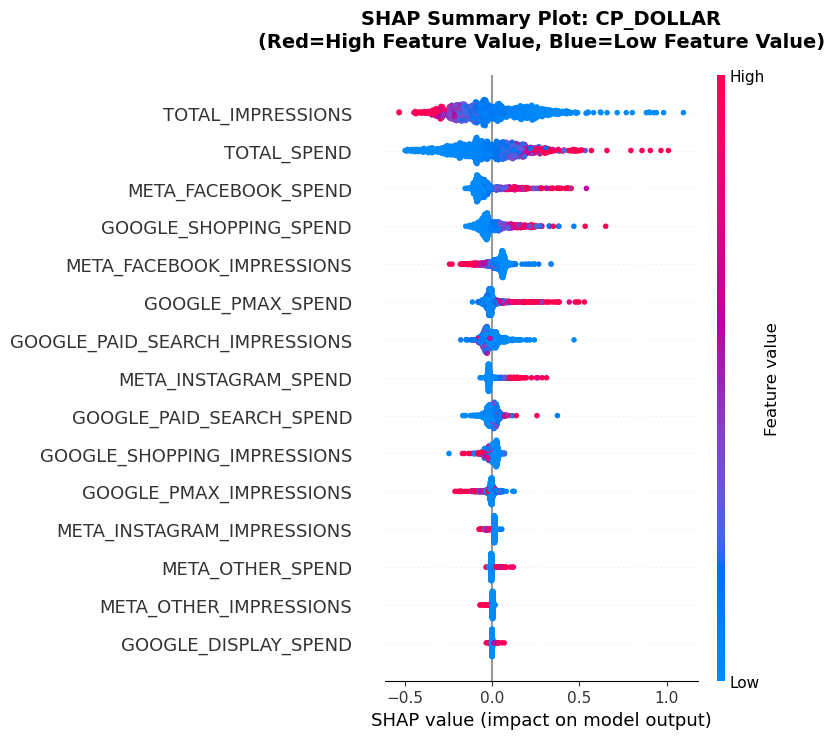

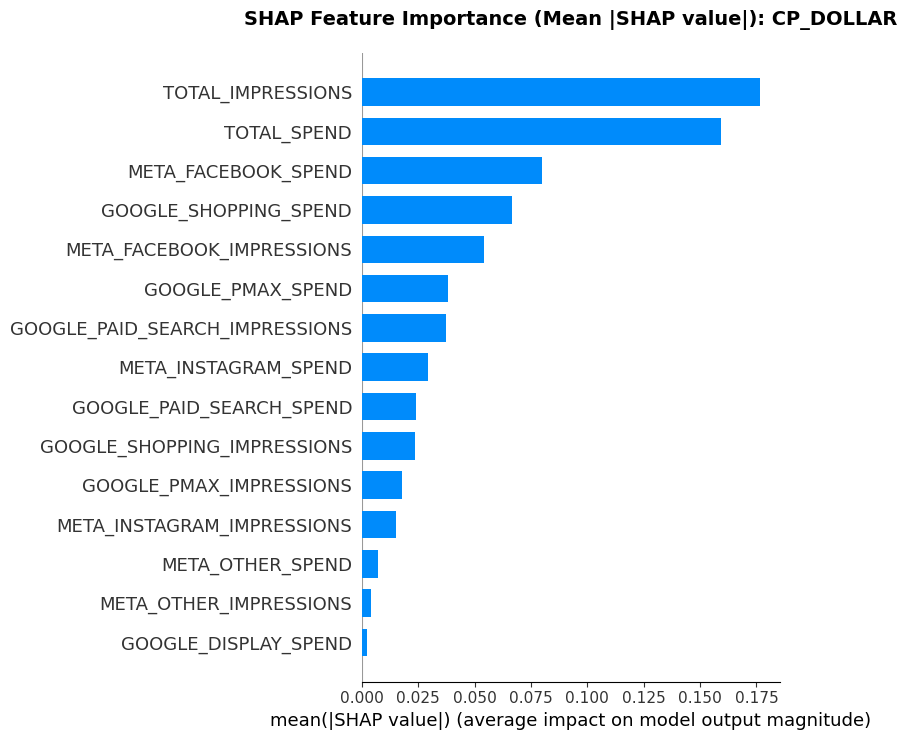

In [100]:
# Create summary plots for each target
for target in target_variables:
    if target not in shap_values_dict:
        continue
        
    print(f"\n{target}:")
    
    try:
        shap_values = shap_values_dict[target]
        
        # Create summary plot (beeswarm plot)
        plt.figure(figsize=(10, 8))
        shap.summary_plot(shap_values, X_shap_sample, 
                        feature_names=feature_names.tolist(),
                        show=False, max_display=15)
        plt.title(f'SHAP Summary Plot: {target}\n(Red=High Feature Value, Blue=Low Feature Value)', 
                    fontsize=14, fontweight='bold', pad=20)
        plt.tight_layout()
        plt.show()
        
        # Create bar plot of mean absolute SHAP values (feature importance)
        plt.figure(figsize=(10, 8))
        shap.summary_plot(shap_values, X_shap_sample,
                        feature_names=feature_names.tolist(),
                        plot_type="bar", show=False, max_display=15)
        plt.title(f'SHAP Feature Importance (Mean |SHAP value|): {target}', 
                    fontsize=14, fontweight='bold', pad=20)
        plt.tight_layout()
        plt.show()
        
    except Exception:
        continue


Waterfall Plots: ROI_FIRST

Example 1:
  Actual prediction: 0.7897664308547974
  Target value: 0.7867132867132868


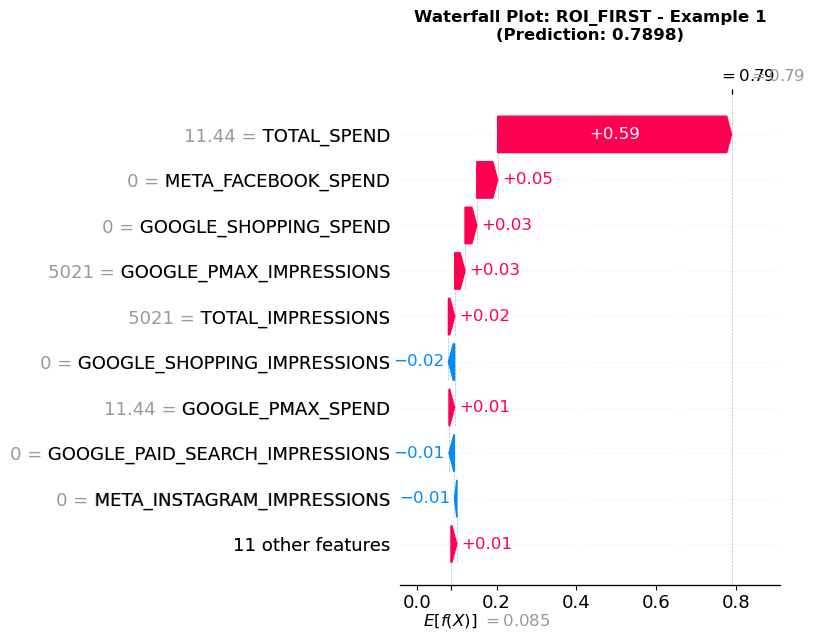


Example 2:
  Actual prediction: 0.009375456720590591
  Target value: 0.008224864571960307


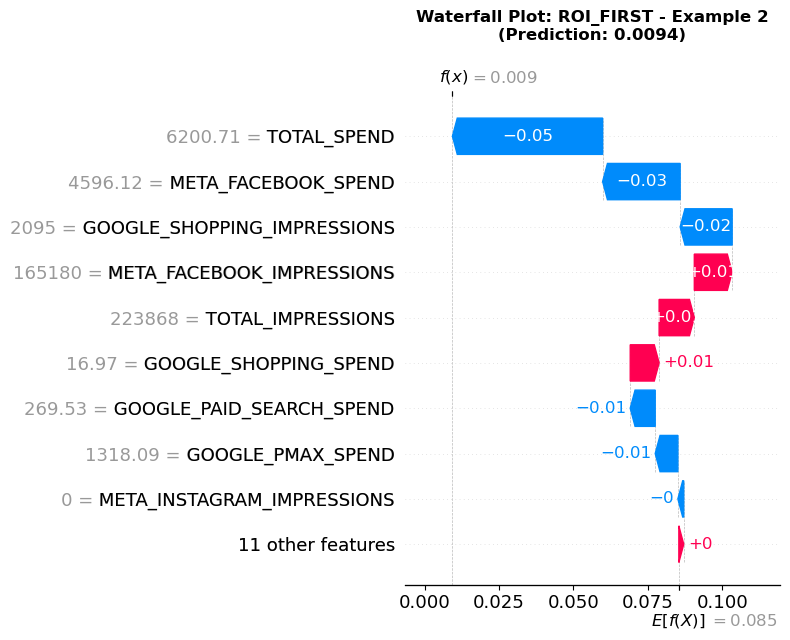


Example 3:
  Actual prediction: -0.005023626144975424
  Target value: 0.00302489488490275


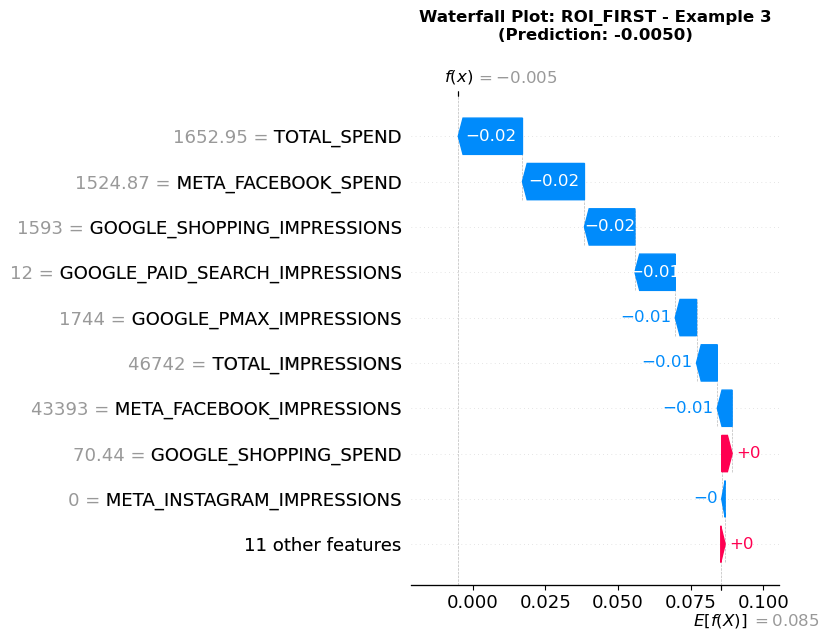

Waterfall Plots: ROI

Example 1:
  Actual prediction: 1.1673017740249634
  Target value: 1.10853848818646


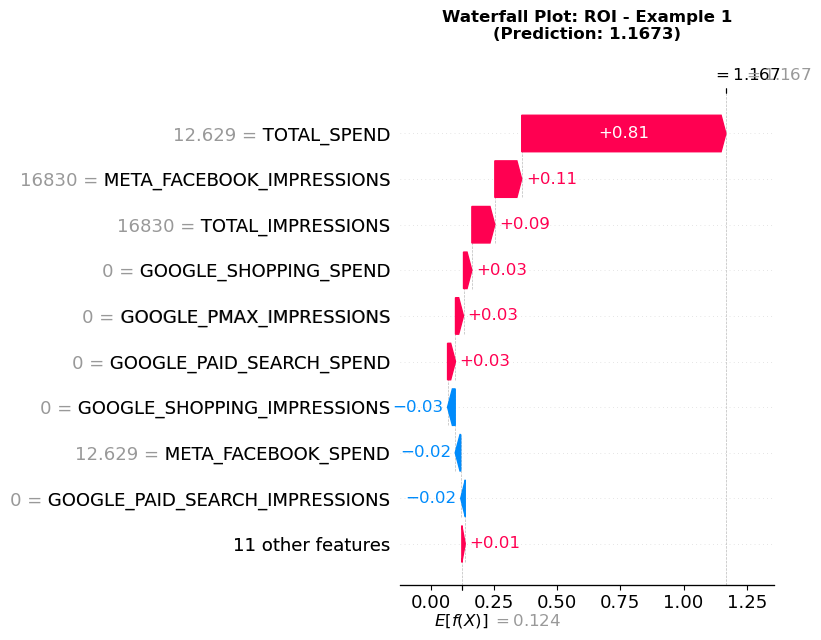


Example 2:
  Actual prediction: 0.017064109444618225
  Target value: 0.010482670532890589


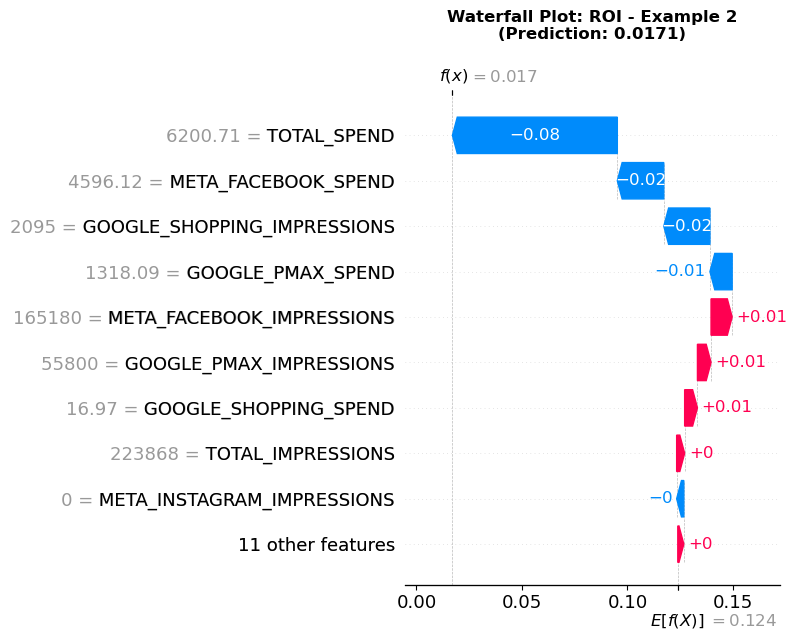


Example 3:
  Actual prediction: -0.00899410992860794
  Target value: 0.00423485283886385


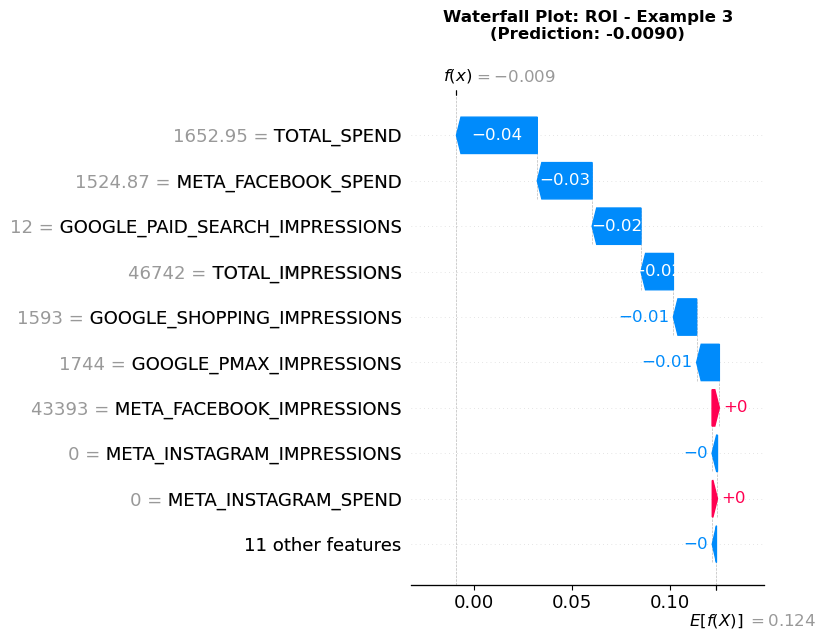

Waterfall Plots: ROI_RETURNING

Example 1:
  Actual prediction: 0.5284155607223511
  Target value: 0.55426924409323


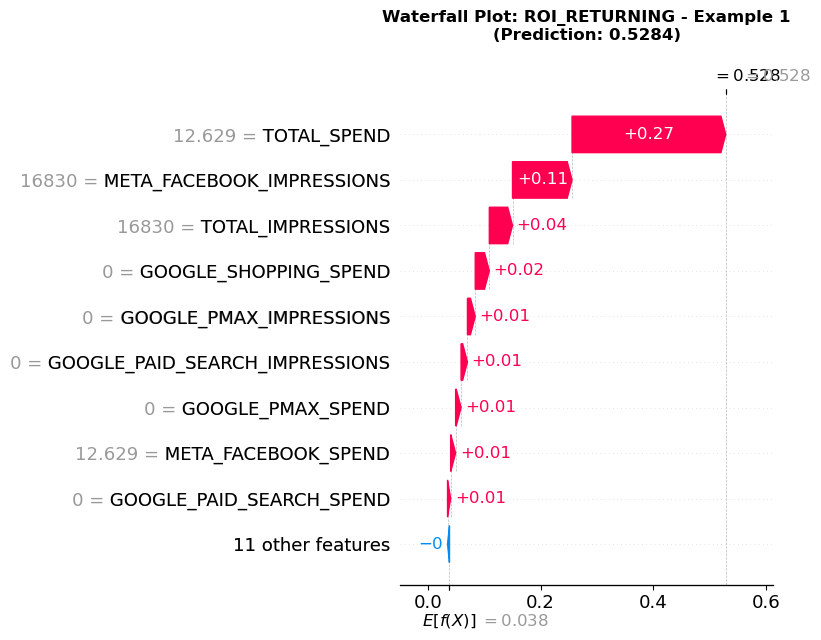


Example 2:
  Actual prediction: 0.005945574026554823
  Target value: 0.0022578059609302805


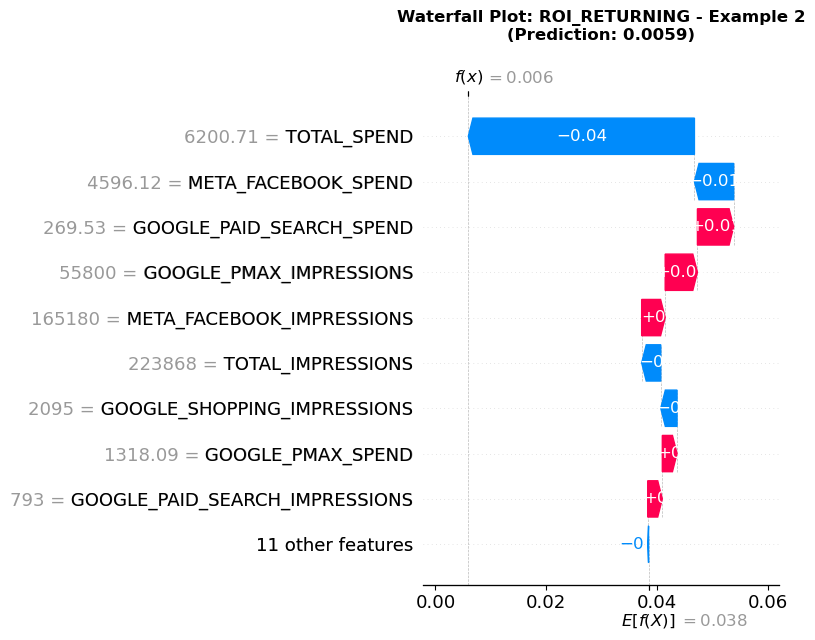


Example 3:
  Actual prediction: -0.007790403440594673
  Target value: 0.002727104081268029


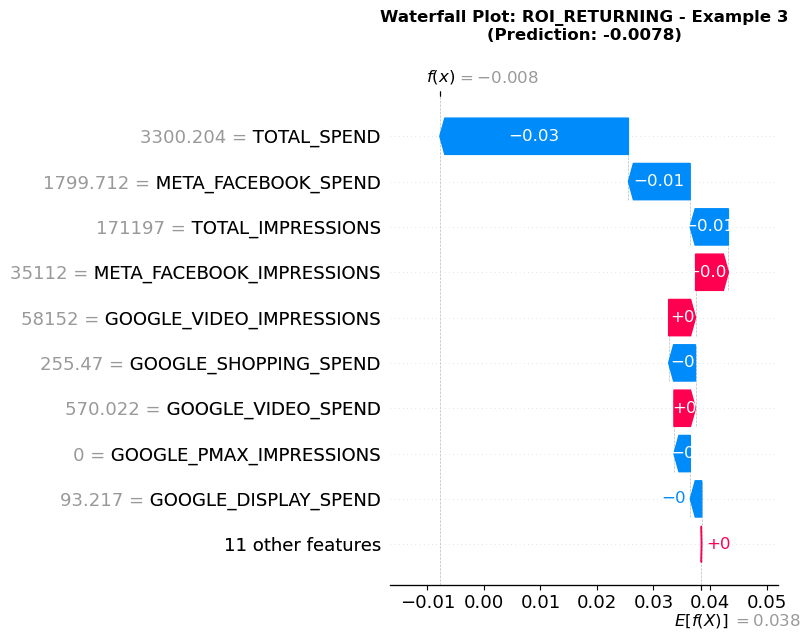

Waterfall Plots: CTR

Example 1:
  Actual prediction: 0.35373416543006897
  Target value: 0.3813095745029316


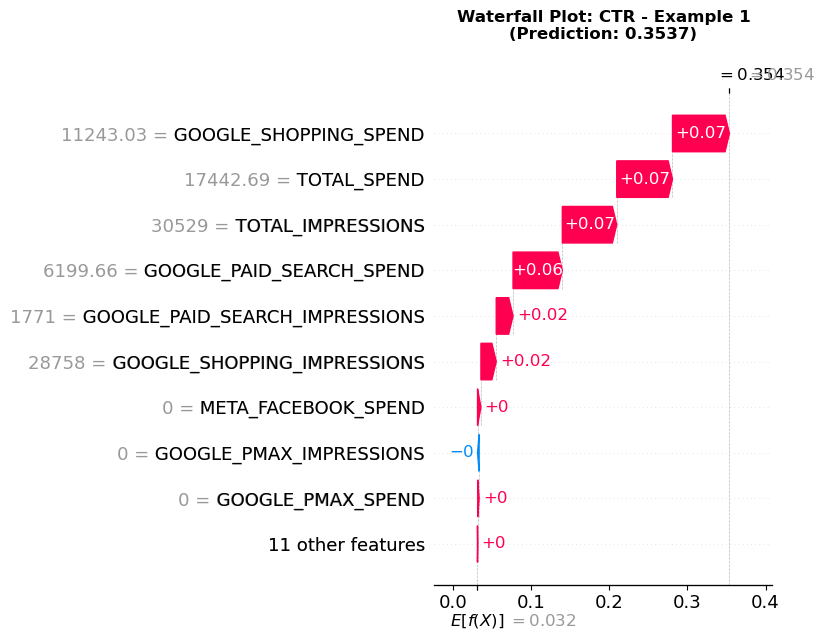


Example 2:
  Actual prediction: 0.02572941593825817
  Target value: 0.0262654778708882


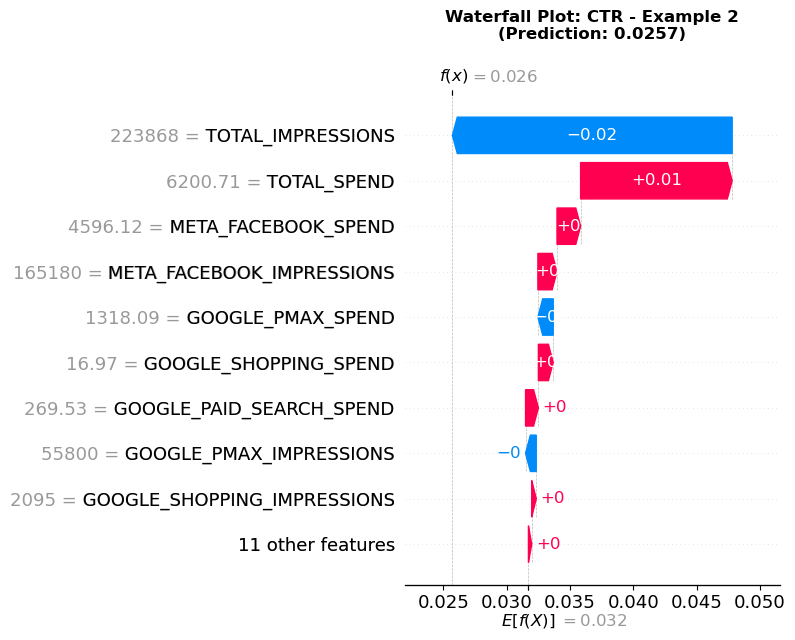


Example 3:
  Actual prediction: 0.004005651921033859
  Target value: 0.007998200915897362


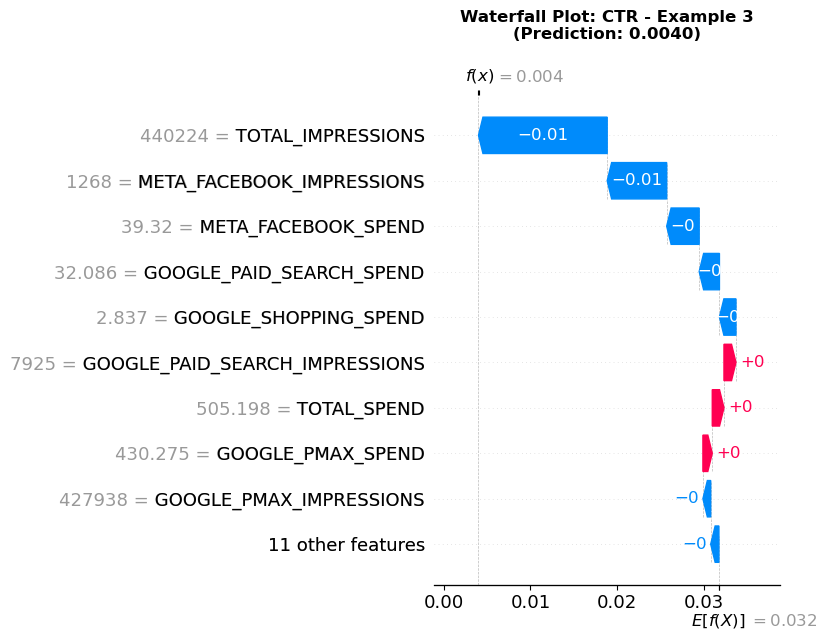

Waterfall Plots: CP_DOLLAR

Example 1:
  Actual prediction: 3.293590784072876
  Target value: 3.539163346613546


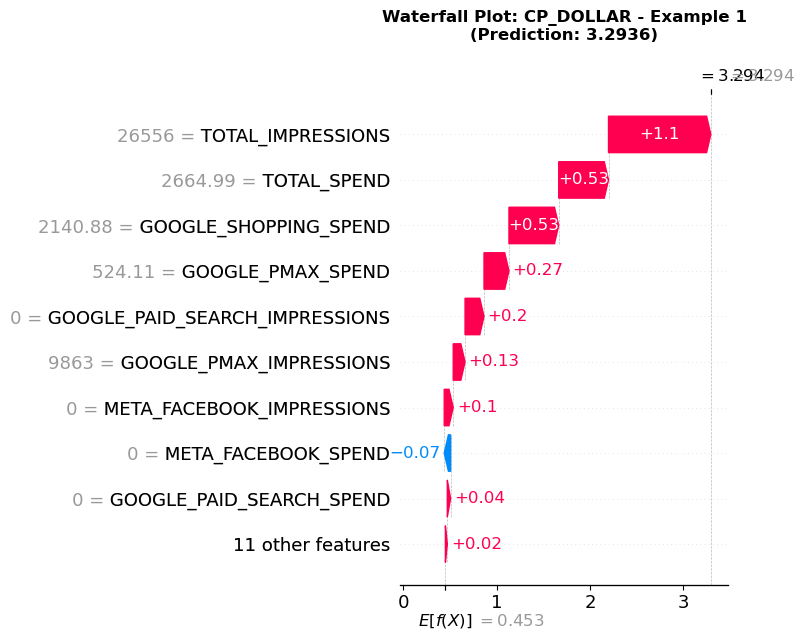


Example 2:
  Actual prediction: 1.3033584356307983
  Target value: 1.0545425170068028


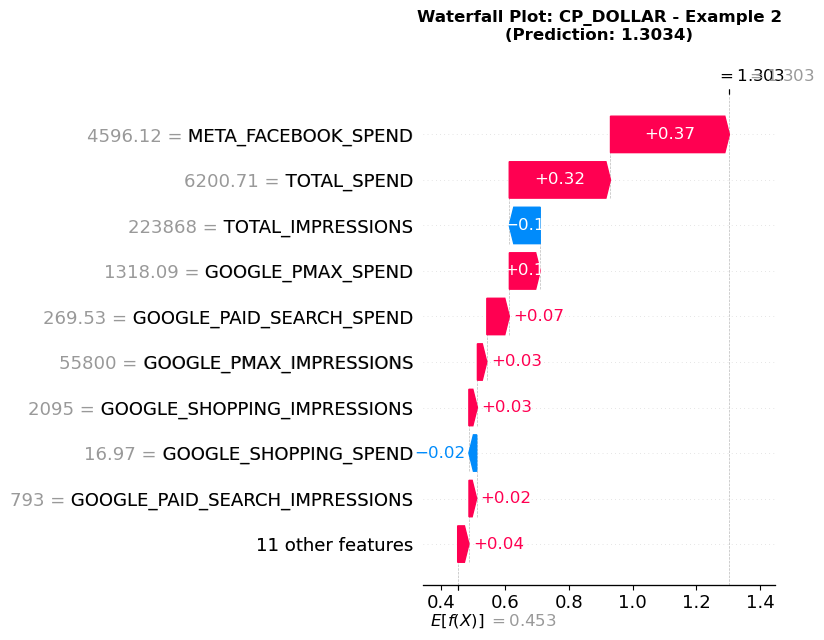


Example 3:
  Actual prediction: 0.015455699525773525
  Target value: 0.023917710196779962


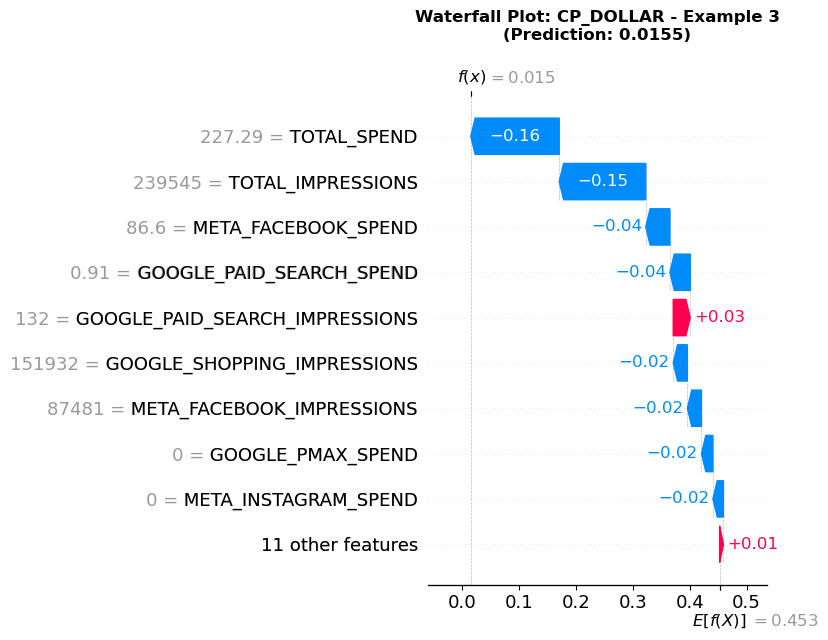

In [101]:
if len(shap_values_dict) > 0:
    for target in target_variables:
        if target not in shap_values_dict:
            continue
        print(f"Waterfall Plots: {target}")
        
        shap_values = shap_values_dict[target]
        explainer = shap_explainers[target]
        
        # Select diverse examples (high, medium, low predictions)
        y_pred_sample = models[target].predict(X_shap_sample)
        high_idx = np.argmax(y_pred_sample)
        low_idx = np.argmin(y_pred_sample)
        med_idx = len(y_pred_sample) // 2
        
        example_indices = [high_idx, med_idx, low_idx]
        
        for example_num, idx in enumerate(example_indices[:3], 1):
            print(f"\nExample {example_num}:")
            print(f"  Actual prediction: {y_pred_sample[idx]}")
            print(f"  Target value: {y_train[target].loc[X_shap_sample.index[idx]]}")
            
            try:
                # Create Explanation object for waterfall plot
                shap_explanation = shap.Explanation(
                    values=shap_values[idx],
                    base_values=explainer.expected_value,
                    data=X_shap_sample.iloc[idx].values,
                    feature_names=X_shap_sample.columns.tolist()
                )
                
                # Create waterfall plot using the newer API
                shap.plots.waterfall(shap_explanation, max_display=10, show=False)
                plt.title(f'Waterfall Plot: {target} - Example {example_num}\n(Prediction: {y_pred_sample[idx]:.4f})',
                         fontsize=12, fontweight='bold', pad=20)
                plt.tight_layout()
                plt.show()
                
            except Exception:
                continue

  1. TOTAL_SPEND
  2. META_FACEBOOK_SPEND
  3. TOTAL_IMPRESSIONS
  4. GOOGLE_PMAX_IMPRESSIONS
  5. GOOGLE_SHOPPING_IMPRESSIONS


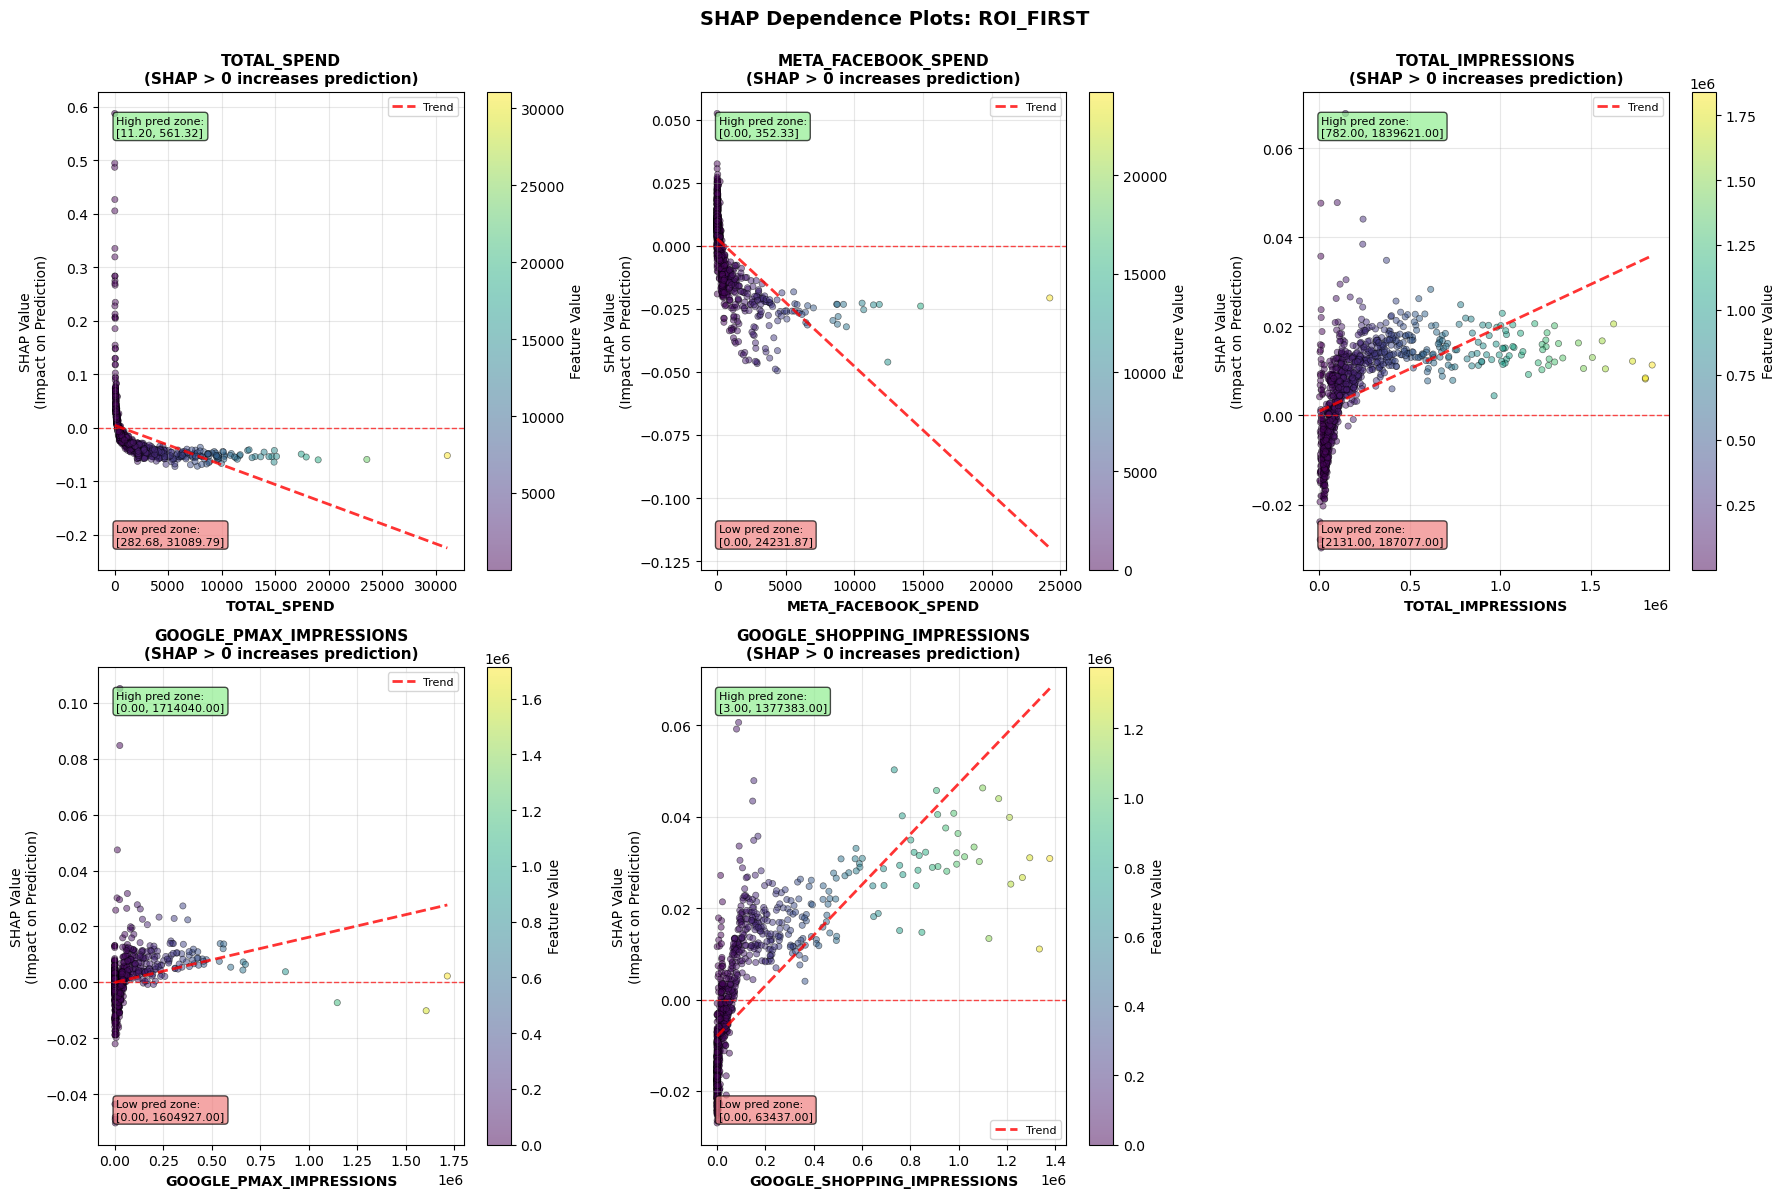


Key Insights for ROI_FIRST:
  • TOTAL_SPEND:
    - Increases predictions when value in range: [11.20, 561.32]
      (Average SHAP impact: +0.0487)
    - Decreases predictions when value in range: [282.68, 31089.79]
      (Average SHAP impact: -0.0309)
  • META_FACEBOOK_SPEND:
    - Increases predictions when value in range: [0.00, 352.33]
      (Average SHAP impact: +0.0100)
    - Decreases predictions when value in range: [0.00, 24231.87]
      (Average SHAP impact: -0.0153)
  • TOTAL_IMPRESSIONS:
    - Increases predictions when value in range: [782.00, 1839621.00]
      (Average SHAP impact: +0.0115)
    - Decreases predictions when value in range: [2131.00, 187077.00]
      (Average SHAP impact: -0.0074)
  • GOOGLE_PMAX_IMPRESSIONS:
    - Increases predictions when value in range: [0.00, 1714040.00]
      (Average SHAP impact: +0.0045)
    - Decreases predictions when value in range: [0.00, 1604927.00]
      (Average SHAP impact: -0.0058)
  • GOOGLE_SHOPPING_IMPRESSIONS:
    - Inc

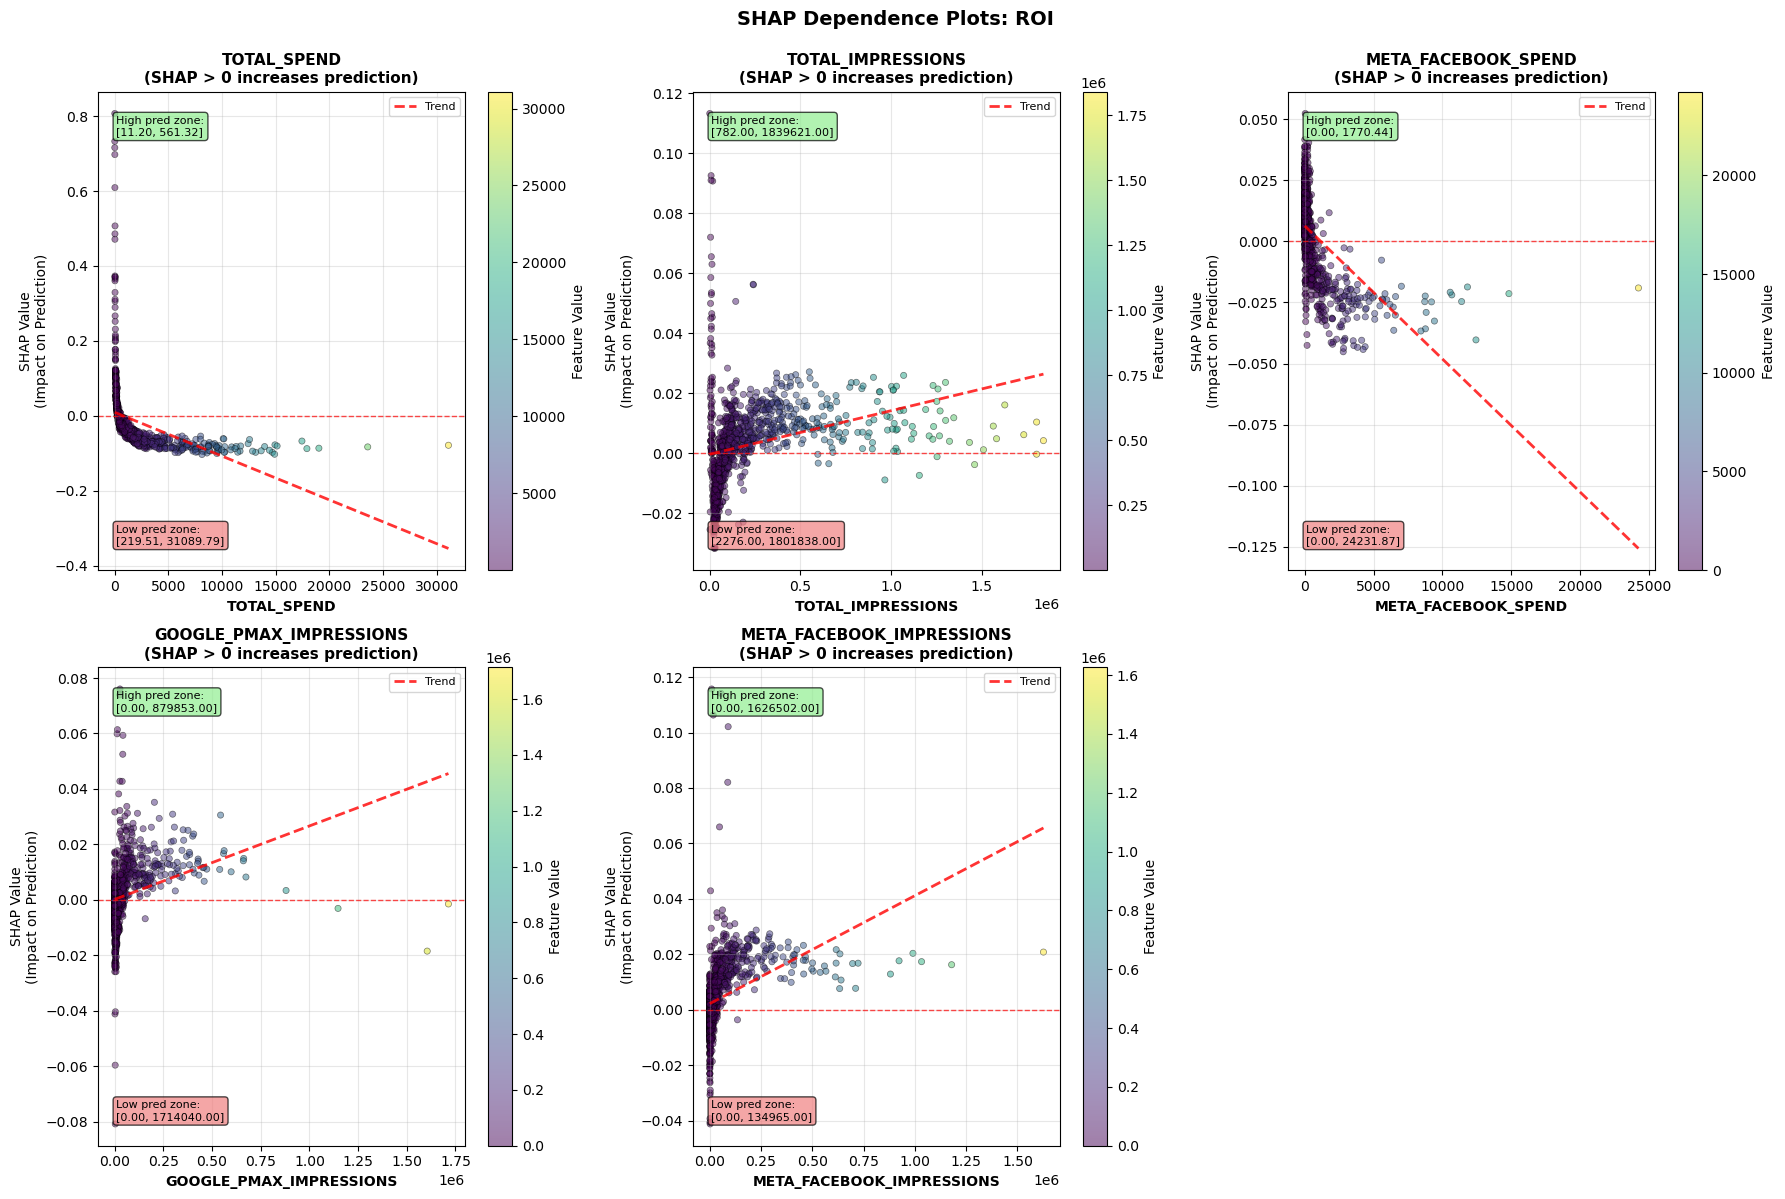


Key Insights for ROI:
  • TOTAL_SPEND:
    - Increases predictions when value in range: [11.20, 561.32]
      (Average SHAP impact: +0.0778)
    - Decreases predictions when value in range: [219.51, 31089.79]
      (Average SHAP impact: -0.0459)
  • TOTAL_IMPRESSIONS:
    - Increases predictions when value in range: [782.00, 1839621.00]
      (Average SHAP impact: +0.0111)
    - Decreases predictions when value in range: [2276.00, 1801838.00]
      (Average SHAP impact: -0.0109)
  • META_FACEBOOK_SPEND:
    - Increases predictions when value in range: [0.00, 1770.44]
      (Average SHAP impact: +0.0130)
    - Decreases predictions when value in range: [0.00, 24231.87]
      (Average SHAP impact: -0.0170)
  • GOOGLE_PMAX_IMPRESSIONS:
    - Increases predictions when value in range: [0.00, 879853.00]
      (Average SHAP impact: +0.0083)
    - Decreases predictions when value in range: [0.00, 1714040.00]
      (Average SHAP impact: -0.0066)
  • META_FACEBOOK_IMPRESSIONS:
    - Increases 

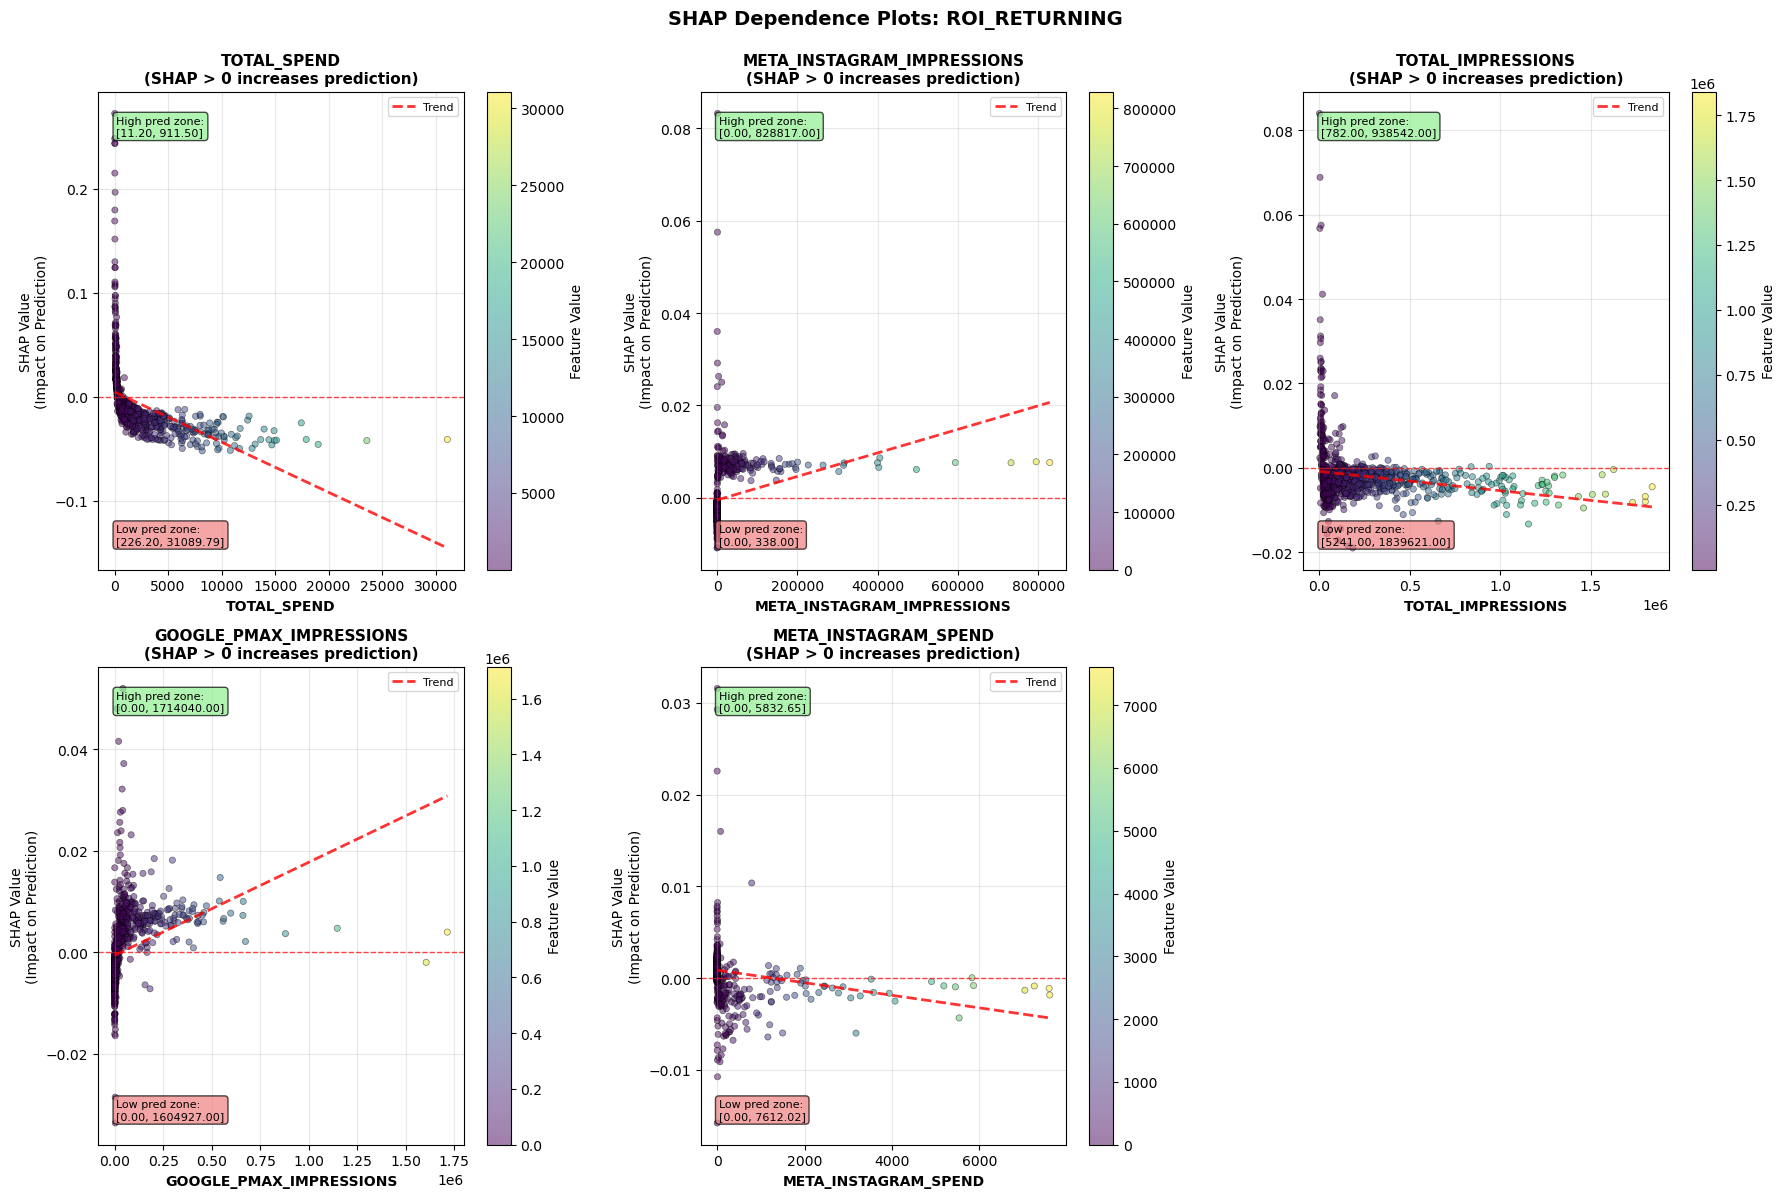


Key Insights for ROI_RETURNING:
  • TOTAL_SPEND:
    - Increases predictions when value in range: [11.20, 911.50]
      (Average SHAP impact: +0.0298)
    - Decreases predictions when value in range: [226.20, 31089.79]
      (Average SHAP impact: -0.0175)
  • META_INSTAGRAM_IMPRESSIONS:
    - Increases predictions when value in range: [0.00, 828817.00]
      (Average SHAP impact: +0.0082)
    - Decreases predictions when value in range: [0.00, 338.00]
      (Average SHAP impact: -0.0021)
  • TOTAL_IMPRESSIONS:
    - Increases predictions when value in range: [782.00, 938542.00]
      (Average SHAP impact: +0.0087)
    - Decreases predictions when value in range: [5241.00, 1839621.00]
      (Average SHAP impact: -0.0038)
  • GOOGLE_PMAX_IMPRESSIONS:
    - Increases predictions when value in range: [0.00, 1714040.00]
      (Average SHAP impact: +0.0070)
    - Decreases predictions when value in range: [0.00, 1604927.00]
      (Average SHAP impact: -0.0040)
  • META_INSTAGRAM_SPEND:
    

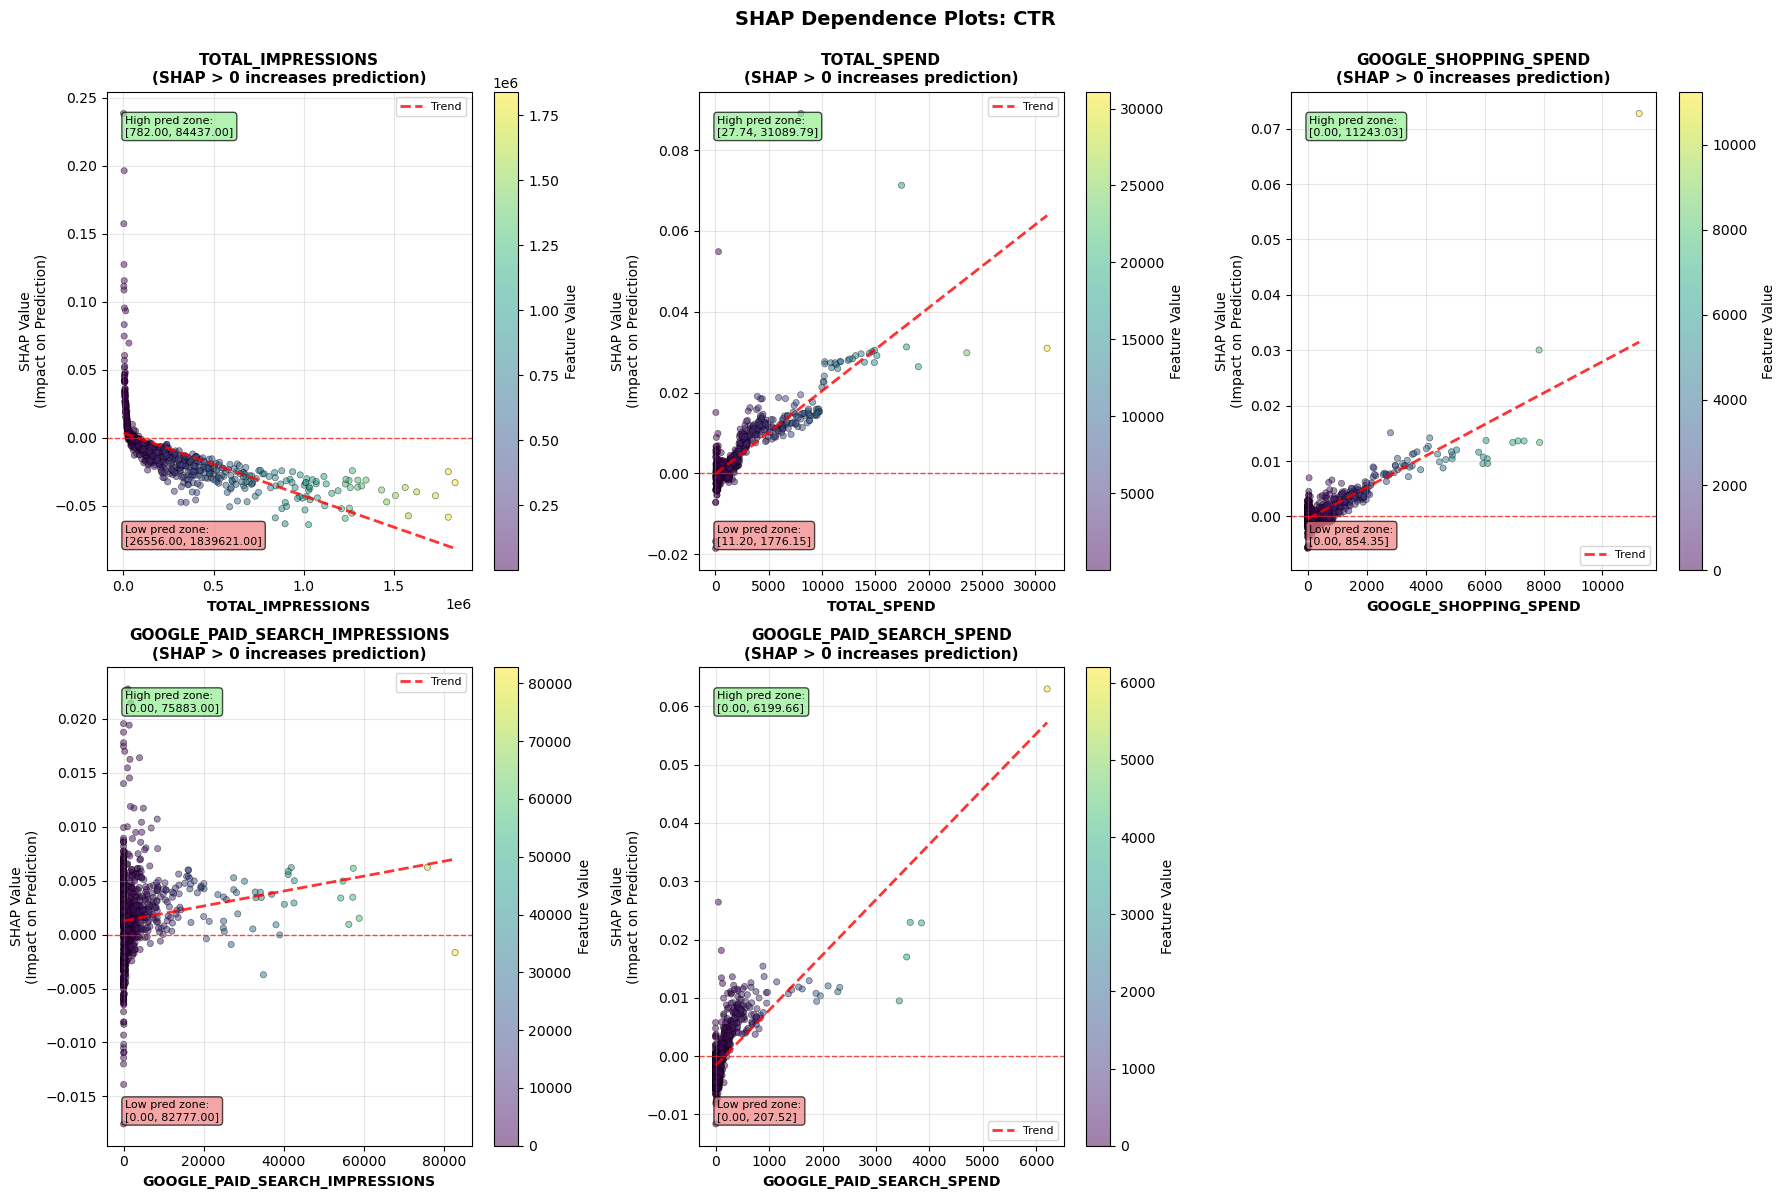


Key Insights for CTR:
  • TOTAL_IMPRESSIONS:
    - Increases predictions when value in range: [782.00, 84437.00]
      (Average SHAP impact: +0.0159)
    - Decreases predictions when value in range: [26556.00, 1839621.00]
      (Average SHAP impact: -0.0145)
  • TOTAL_SPEND:
    - Increases predictions when value in range: [27.74, 31089.79]
      (Average SHAP impact: +0.0054)
    - Decreases predictions when value in range: [11.20, 1776.15]
      (Average SHAP impact: -0.0016)
  • GOOGLE_SHOPPING_SPEND:
    - Increases predictions when value in range: [0.00, 11243.03]
      (Average SHAP impact: +0.0025)
    - Decreases predictions when value in range: [0.00, 854.35]
      (Average SHAP impact: -0.0008)
  • GOOGLE_PAID_SEARCH_IMPRESSIONS:
    - Increases predictions when value in range: [0.00, 75883.00]
      (Average SHAP impact: +0.0033)
    - Decreases predictions when value in range: [0.00, 82777.00]
      (Average SHAP impact: -0.0024)
  • GOOGLE_PAID_SEARCH_SPEND:
    - Increas

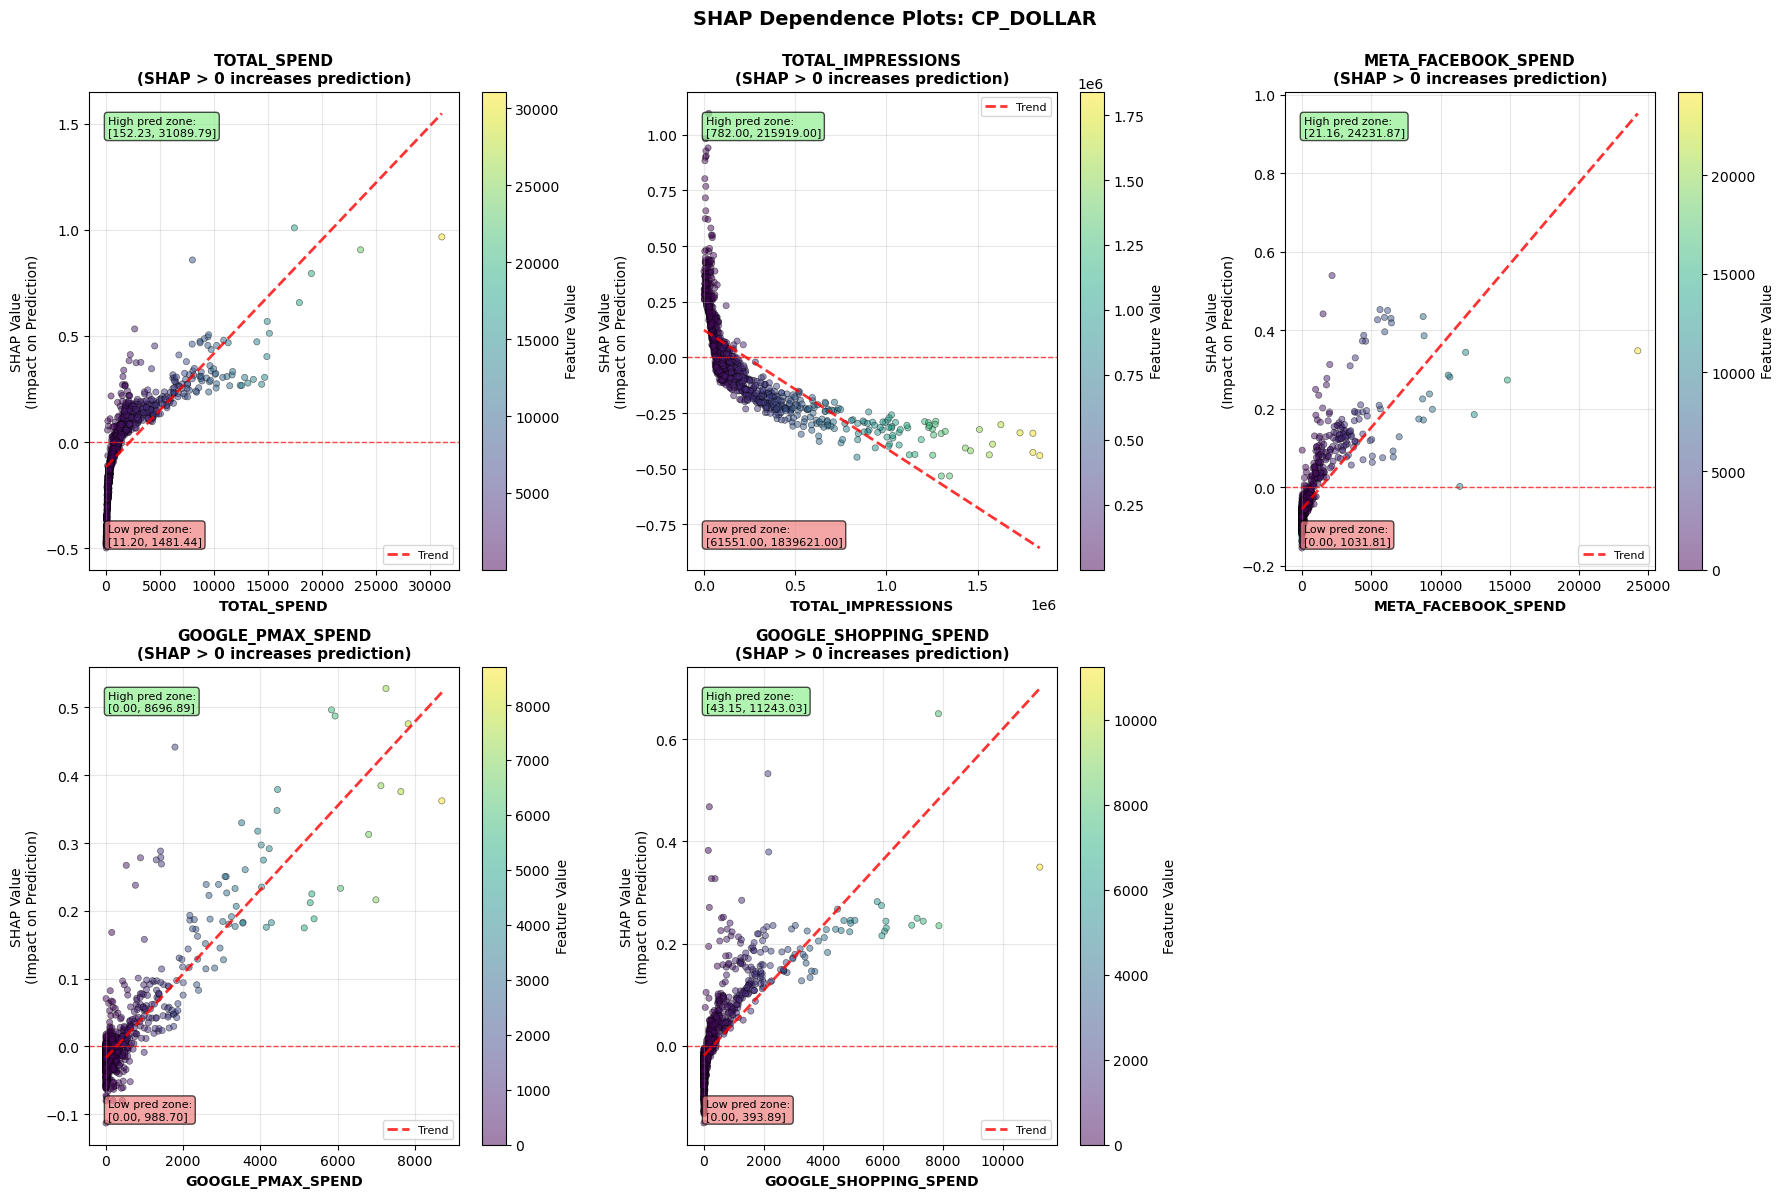


Key Insights for CP_DOLLAR:
  • TOTAL_SPEND:
    - Increases predictions when value in range: [152.23, 31089.79]
      (Average SHAP impact: +0.1595)
    - Decreases predictions when value in range: [11.20, 1481.44]
      (Average SHAP impact: -0.1595)
  • TOTAL_IMPRESSIONS:
    - Increases predictions when value in range: [782.00, 215919.00]
      (Average SHAP impact: +0.1995)
    - Decreases predictions when value in range: [61551.00, 1839621.00]
      (Average SHAP impact: -0.1578)
  • META_FACEBOOK_SPEND:
    - Increases predictions when value in range: [21.16, 24231.87]
      (Average SHAP impact: +0.1289)
    - Decreases predictions when value in range: [0.00, 1031.81]
      (Average SHAP impact: -0.0671)
  • GOOGLE_PMAX_SPEND:
    - Increases predictions when value in range: [0.00, 8696.89]
      (Average SHAP impact: +0.0794)
    - Decreases predictions when value in range: [0.00, 988.70]
      (Average SHAP impact: -0.0206)
  • GOOGLE_SHOPPING_SPEND:
    - Increases predicti

In [102]:
if len(shap_values_dict) > 0:
    
    for target in target_variables:
        if target not in shap_values_dict:
            continue
        
        # Get top features
        importances = models[target].feature_importances_
        # Analyze top 5 features
        feature_indices = np.argsort(importances)[::-1][:5]
        top_features = [feature_names[i] for i in feature_indices]
        for i, feat in enumerate(top_features, 1):
            print(f"  {i}. {feat}")
        
        shap_values = shap_values_dict[target]
        
        # Create dependence plots for top features
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes = axes.flatten()
        
        for idx, feat_name in enumerate(top_features[:6]):  # Show up to 6 features
            if idx >= len(axes):
                break
                
            ax = axes[idx]
            
            try:
                # Get feature index
                feat_idx = list(feature_names).index(feat_name)
                
                # Get feature values and SHAP values for this feature
                feat_values = X_shap_sample.iloc[:, feat_idx].values
                shap_vals = shap_values[:, feat_idx]
                
                # Create scatter plot
                scatter = ax.scatter(feat_values, shap_vals, alpha=0.5, s=20, c=feat_values, 
                                   cmap='viridis', edgecolors='black', linewidth=0.5)
                
                # Add horizontal line at y=0
                ax.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.7)
                
                # Identify zones where SHAP is positive (increases prediction) vs negative
                positive_mask = shap_vals > 0
                negative_mask = shap_vals < 0
                
                # Add trend line
                if len(feat_values) > 10:
                    z = np.polyfit(feat_values, shap_vals, 1)
                    p = np.poly1d(z)
                    sorted_indices = np.argsort(feat_values)
                    ax.plot(feat_values[sorted_indices], p(feat_values[sorted_indices]), 
                           "r--", alpha=0.8, linewidth=2, label='Trend')
                
                # Annotate high/low impact zones
                if np.any(positive_mask):
                    high_feat_values = feat_values[positive_mask]
                    if len(high_feat_values) > 0:
                        ax.text(0.05, 0.95, 
                               f'High pred zone:\n[{high_feat_values.min():.2f}, {high_feat_values.max():.2f}]',
                               transform=ax.transAxes, fontsize=8, verticalalignment='top',
                               bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))
                
                if np.any(negative_mask):
                    low_feat_values = feat_values[negative_mask]
                    if len(low_feat_values) > 0:
                        ax.text(0.05, 0.05, 
                               f'Low pred zone:\n[{low_feat_values.min():.2f}, {low_feat_values.max():.2f}]',
                               transform=ax.transAxes, fontsize=8, verticalalignment='bottom',
                               bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7))
                
                ax.set_xlabel(f'{feat_name}', fontsize=10, fontweight='bold')
                ax.set_ylabel('SHAP Value\n(Impact on Prediction)', fontsize=10)
                ax.set_title(f'{feat_name}\n(SHAP > 0 increases prediction)', 
                           fontsize=11, fontweight='bold')
                ax.grid(True, alpha=0.3)
                ax.legend(fontsize=8)
                
                # Add colorbar
                plt.colorbar(scatter, ax=ax, label='Feature Value')
                
            except Exception as e:
                ax.text(0.5, 0.5, f'Error:\n{str(e)}', 
                       transform=ax.transAxes, ha='center', va='center')
                ax.set_title(feat_name)
        
        # Hide unused subplots
        for idx in range(len(top_features), len(axes)):
            axes[idx].axis('off')
        
        plt.suptitle(f'SHAP Dependence Plots: {target}', fontsize=14, fontweight='bold', y=0.995)
        plt.tight_layout()
        plt.show()
        
        # Print insights
        print(f"\nKey Insights for {target}:")
        for feat_name in top_features:
            try:
                feat_idx = list(feature_names).index(feat_name)
                feat_values = X_shap_sample.iloc[:, feat_idx].values
                shap_vals = shap_values[:, feat_idx]
                
                # Find feature value ranges where SHAP is positive (high impact)
                positive_mask = shap_vals > 0
                negative_mask = shap_vals < 0
                
                if np.any(positive_mask):
                    high_feat_range = (feat_values[positive_mask].min(), feat_values[positive_mask].max())
                    avg_shap_high = np.mean(shap_vals[positive_mask])
                    print(f"  • {feat_name}:")
                    print(f"    - Increases predictions when value in range: [{high_feat_range[0]:.2f}, {high_feat_range[1]:.2f}]")
                    print(f"      (Average SHAP impact: +{avg_shap_high:.4f})")
                
                if np.any(negative_mask):
                    low_feat_range = (feat_values[negative_mask].min(), feat_values[negative_mask].max())
                    avg_shap_low = np.mean(shap_vals[negative_mask])
                    print(f"    - Decreases predictions when value in range: [{low_feat_range[0]:.2f}, {low_feat_range[1]:.2f}]")
                    print(f"      (Average SHAP impact: {avg_shap_low:.4f})")
                    
            except Exception:
                continue
